In [1]:
import sys
import yaml
import torch
import logging
from pathlib import Path

# Add the path to the directory containing the omnicell package
# Assuming the omnicell package is in the parent directory of your notebook
sys.path.append('/orcd/data/omarabu/001/tanush20/omnicell/')  # Adjust this path as needed

import yaml
import torch
import logging
from pathlib import Path
from omnicell.config.config import Config, ETLConfig, ModelConfig, DatasplitConfig, EvalConfig, EmbeddingConfig
from omnicell.data.loader import DataLoader
from omnicell.constants import PERT_KEY, GENE_EMBEDDING_KEY, CONTROL_PERT
from omnicell.models.scot.scot import SCOT
from omnicell.models.scot.proportional import ProportionalSCOT
from omnicell.models.selector import load_model as get_model

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Configure paths
MODEL_CONFIG = ModelConfig.from_yaml("/orcd/data/omarabu/001/tanush20/omnicell/configs/models/scot/scot.yaml")
ETL_CONFIG = ETLConfig(name = "no_preprocessing", log1p = False, drop_unmatched_perts = False)
EMBEDDING_CONFIG = EmbeddingConfig(pert_embedding='GenePT')

SPLIT_CONFIG = DatasplitConfig.from_yaml("/orcd/data/omarabu/001/njwfish/omnicell/configs/splits/repogle_k562_essential_raw/random_splits/rs_accP_k562_ood_ss:ns_20_2_most_pert_0.1/split_0/split_config.yaml")
EVAL_CONFIG = EvalConfig.from_yaml("/orcd/data/omarabu/001/njwfish/omnicell/configs/splits/repogle_k562_essential_raw/random_splits/rs_accP_k562_ood_ss:ns_20_2_most_pert_0.1/split_0/eval_config.yaml")  # Set this if you want to run evaluations

# Load configurations
config = Config(model_config=MODEL_CONFIG,
                 etl_config=ETL_CONFIG, 
                 datasplit_config=SPLIT_CONFIG, 
                 eval_config=EVAL_CONFIG)




#Alternatively you can initialize the config objects manually as follows:
# etl_config = ETLConfig(name = XXX, log1p = False, drop_unmatched_perts = False, ...)
# model_config = ...
# embedding_config = ...
# datasplit_config = ...
# eval_config = ...
# config = Config(etl_config, model_config, datasplit_config, eval_config)

# Set up device

[KeOps] Warning : Cuda libraries were not detected on the system or could not be loaded ; using cpu only mode


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize data loader and load training data
loader = DataLoader(config)
adata, pert_rep_map = loader.get_training_data()

# Get dimensions and perturbation IDs
input_dim = adata.shape[1]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pert_ids = adata.obs[PERT_KEY].unique()
gene_emb_dim = adata.varm[GENE_EMBEDDING_KEY].shape[1] if GENE_EMBEDDING_KEY in adata.varm else None

print(f"Data loaded:")
print(f"- Number of cells: {adata.shape[0]}")
print(f"- Input dimension: {input_dim}")
print(f"- Number of perturbations: {len(pert_ids)}")


2025-02-20 10:26:34,018 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/DatlingerBock2017.yaml
2025-02-20 10:26:34,020 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/SchraivogelSteinmetz2020_TAP_SCREEN__chromosome_11_screen.yaml
2025-02-20 10:26:34,022 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/ReplogleWeissman2022_K562_essential.yaml
2025-02-20 10:26:34,023 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/GasperiniShendure2019_atscale.yaml
2025-02-20 10:26:34,025 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/TianKampmann2021_CRISPRa.yaml
2025-02-20 10:26:34,027 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/repogle_k562_essential_raw.yaml
2025-02-20 10:26:34,029 - INFO - Loading data catalogue from /

Using device: cuda


2025-02-20 10:26:37,356 - INFO - Loaded unpreprocessed data, # of data points: 310385, # of genes: 8563.
2025-02-20 10:26:37,357 - INFO - Preprocessing training data
2025-02-20 10:26:37,359 - INFO - Using identity features for perturbations
2025-02-20 10:27:02,207 - INFO - Doing OOD split


Data loaded:
- Number of cells: 304701
- Input dimension: 8563
- Number of perturbations: 2038


In [3]:
model = get_model(config.model_config, loader, pert_rep_map, input_dim, device, pert_ids)

2025-02-20 10:27:02,333 - INFO - SCOT model selected


## Sliced Wasserstein L2 metric

In [5]:
model.train(adata, None)

Creating source indices
Creating target indices
Creating pert indices
Creating source and target dicts
Strata probs [1.70062243e-05 1.70062243e-05 1.70062243e-05 ... 3.31281249e-03
 3.37403490e-03 6.78888473e-03]


2025-02-19 10:01:46,835 - INFO - Training for 20 epochs
2025-02-19 10:02:41,317 - INFO - Epoch 1/20 - Loss: 3.245185139971605
2025-02-19 10:03:35,374 - INFO - Epoch 2/20 - Loss: 2.244051140533832
2025-02-19 10:04:29,152 - INFO - Epoch 3/20 - Loss: 1.519021502445484
2025-02-19 10:05:23,406 - INFO - Epoch 4/20 - Loss: 1.3292251185601325
2025-02-19 10:06:17,810 - INFO - Epoch 5/20 - Loss: 1.196704192135554
2025-02-19 10:07:12,121 - INFO - Epoch 6/20 - Loss: 1.2059042644259383
2025-02-19 10:08:06,131 - INFO - Epoch 7/20 - Loss: 1.096266179678259
2025-02-19 10:08:59,933 - INFO - Epoch 8/20 - Loss: 1.0582533931433087
2025-02-19 10:09:54,010 - INFO - Epoch 9/20 - Loss: 1.1539859842471403
2025-02-19 10:10:48,094 - INFO - Epoch 10/20 - Loss: 1.0910382713679667
2025-02-19 10:11:41,984 - INFO - Epoch 11/20 - Loss: 1.0646567126044957
2025-02-19 10:12:35,999 - INFO - Epoch 12/20 - Loss: 1.0934381981762347
2025-02-19 10:13:30,289 - INFO - Epoch 13/20 - Loss: 1.0258206427539163
2025-02-19 10:14:24,30

In [6]:
import numpy as np

logger.info("Running evaluation")

# evaluate each pair of cells and perts
i=0
eval_dict = {}
for cell_id, pert_id, ctrl_data, gt_data in loader.get_eval_data():
    logger.debug(f"Making predictions for cell: {cell_id}, pert: {pert_id}")

    preds = model.make_predict(ctrl_data, pert_id = pert_id, cell_type = cell_id)
    eval_dict[(cell_id, pert_id)] = (ctrl_data.X.toarray(), gt_data.X.toarray(), preds)
    i=i+1
    if(i==20):
        break
    
if not config.etl_config.log1p:
    for (cell, pert) in eval_dict:  
        ctrl_data, gt_data, pred_pert = eval_dict[(cell, pert)]
        # normalize to sum to 1
        ctrl_data = ctrl_data / ctrl_data.sum(axis=1).reshape(-1, 1) * 10_000
        gt_data = gt_data / gt_data.sum(axis=1).reshape(-1, 1) * 10_000
        pred_pert = pred_pert / pred_pert.sum(axis=1).reshape(-1, 1) * 10_000
        eval_dict[(cell, pert)] =  (np.log1p(ctrl_data), np.log1p(gt_data), np.log1p(pred_pert))

import scanpy as sc
from omnicell.evaluation.utils import get_DEGs, get_eval, get_DEG_Coverage_Recall, get_DEGs_overlaps
pval_threshold = 0.05
log_fold_change_threshold = 0.0

results_dict = {}
for (cell, pert) in eval_dict:  
    ctrl_data, gt_data, pred_pert = eval_dict[(cell, pert)]

    pred_pert = sc.AnnData(X=pred_pert)
    true_pert = sc.AnnData(X=gt_data)
    control = sc.AnnData(X=ctrl_data)

    logger.debug(f"Getting ground Truth DEGs for {pert} and {cell}")
    true_DEGs_df = get_DEGs(control, true_pert)
    signif_true_DEG = true_DEGs_df[true_DEGs_df['pvals_adj'] < pval_threshold]

    logger.debug(f"Number of significant DEGS from ground truth: {signif_true_DEG.shape[0]}")

    logger.debug(f"Getting predicted DEGs for {pert} and {cell}")
    pred_DEGs_df = get_DEGs(control, pred_pert)


    logger.debug(f"Getting evaluation metrics for {pert} and {cell}")
    r2_and_mse = get_eval(control, true_pert, pred_pert, true_DEGs_df, [100,50,20], pval_threshold, log_fold_change_threshold)

    logger.debug(f"Getting DEG overlaps for {pert} and {cell}")
    DEGs_overlaps = get_DEGs_overlaps(true_DEGs_df, pred_DEGs_df, [100,50,20], pval_threshold, log_fold_change_threshold)

    results_dict[(cell, pert)] = (r2_and_mse, DEGs_overlaps)



2025-02-19 10:19:48,740 - INFO - Running evaluation
2025-02-19 10:19:48,741 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/DatlingerBock2017.yaml
2025-02-19 10:19:48,744 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/SchraivogelSteinmetz2020_TAP_SCREEN__chromosome_11_screen.yaml
2025-02-19 10:19:48,746 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/ReplogleWeissman2022_K562_essential.yaml
2025-02-19 10:19:48,748 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/GasperiniShendure2019_atscale.yaml
2025-02-19 10:19:48,750 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/TianKampmann2021_CRISPRa.yaml
2025-02-19 10:19:48,752 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/repogle_k562_essential_raw.yaml
2025-02-19

/home/tanush20/anaconda3/envs/omnicell/lib/python3.9/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/tanush20/anaconda3/envs/omnicell/lib/python3.9/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/tanush20/anaconda3/envs/omnicell/lib/python3.9/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/tanush20/anaconda3/envs/omnicell/lib/python3.9/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/tanush20/anaconda3/envs/omnicell/lib/python3.9/site-packag

In [7]:
DEG_20_overlap = []
DEG_50_overlap = []
DEG_100_overlap = []
jaccard = []
r2_and_mse_20 = []
r2_and_mse_50 = []
r2_and_mse_100 = []
all_genes_r2 = []
dicts_r2 = []
dicts_DEG = []
for (cell, pert) in results_dict:
    r2_and_mse, DEGs_overlaps = results_dict[(cell, pert)]
    print(r2_and_mse['Top_100_DEGs_var_R2'])
    dicts_r2.append(r2_and_mse)
    dicts_DEG.append(DEGs_overlaps)
    DEG_20_overlap.append(DEGs_overlaps['Overlap_in_top_20_DEGs'])
    DEG_50_overlap.append(DEGs_overlaps['Overlap_in_top_50_DEGs'])
    DEG_100_overlap.append(DEGs_overlaps['Overlap_in_top_100_DEGs'])
    jaccard.append(DEGs_overlaps['Jaccard'])
    r2_and_mse_20.append(r2_and_mse['Top_20_DEGs_mean_R2'])
    r2_and_mse_50.append(r2_and_mse['Top_50_DEGs_mean_R2'])
    r2_and_mse_100.append(r2_and_mse['Top_100_DEGs_mean_R2'])
    all_genes_r2.append(r2_and_mse['all_genes_mean_R2'])

    print(f"Cell: {cell}, Pert: {pert}")
    # print(f"R2 and MSE: {r2_and_mse}")
    print(f"DEGs Overlaps: {DEGs_overlaps}")
    print("-"*100)

0.35489082260643795
Cell: k562, Pert: RPL15
DEGs Overlaps: {'Overlap_in_top_2157_DEGs': 1446, 'Overlap_in_top_100_DEGs': 72, 'Overlap_in_top_50_DEGs': 32, 'Overlap_in_top_20_DEGs': 9, 'Jaccard': 0.331319399085565}
----------------------------------------------------------------------------------------------------
0.7174968932635966
Cell: k562, Pert: U2AF1
DEGs Overlaps: {'Overlap_in_top_3107_DEGs': 2221, 'Overlap_in_top_100_DEGs': 75, 'Overlap_in_top_50_DEGs': 39, 'Overlap_in_top_20_DEGs': 12, 'Jaccard': 0.46053469127943986}
----------------------------------------------------------------------------------------------------
0.21338785220112613
Cell: k562, Pert: RPL4
DEGs Overlaps: {'Overlap_in_top_3714_DEGs': 1717, 'Overlap_in_top_100_DEGs': 64, 'Overlap_in_top_50_DEGs': 32, 'Overlap_in_top_20_DEGs': 14, 'Jaccard': 0.35726175613816064}
----------------------------------------------------------------------------------------------------
0.27121373658435344
Cell: k562, Pert: RPL7
DEGs Ove

In [9]:
averaged_dict = {}

# Iterate over all possible keys (from all dictionaries)
all_keys = set(key for d in dicts_r2 for key in d)

# Number of dictionaries
n = len(dicts_r2)

# Iterate over each key
for key in all_keys:
    # Sum up the values for the current key across dictionaries that have it
    total = 0
    count = 0
    for d in dicts_r2:
        if key in d:
            total += d[key]
            count += 1
    
    # If the key appeared in any dictionary, calculate the average
    if count > 0:
        averaged_dict[key] = total / count

# Print the result
for key, value in averaged_dict.items():
    print(f"{key}: {value}")
import pickle
with open('./loss_results/baseline_sw_l2_r2.pkl', 'wb') as f:
    pickle.dump(averaged_dict, f)

Top_3845_DEGs_fold_diff_MSE: 0.49026116728782654
Top_3430_DEGs_corr_mtx_MSE: 0.0046432138318905965
Top_3226_DEGs_corr_mtx_R2: 0.08266880149807564
Top_50_DEGs_var_MSE: 0.06648519125301391
Top_2812_DEGs_sub_diff_R2: 0.9336463229402778
Top_3240_DEGs_mean_MSE: 0.0024875805247575045
Top_3107_DEGs_cov_mtx_R2: 0.12096751032436544
Top_3483_DEGs_var_MSE: 0.002260665176436305
Top_4053_DEGs_fold_diff_R2: 0.968587787854177
Top_2157_DEGs_corr_mtx_R2: 0.12950260315078646
Top_4535_DEGs_cov_mtx_R: 0.2651008557885549
Top_3107_DEGs_corr_mtx_MSE: 0.011985880082151715
Top_3483_DEGs_corr_mtx_R: 0.3964530748716479
Top_100_DEGs_mean_R2: 0.9914059032014766
Top_50_DEGs_corr_mtx_R2: 0.44522909348549505
Top_3408_DEGs_fold_diff_R2: 0.9371402652027173
Top_3107_DEGs_fold_diff_R: 0.9902973286798676
Top_50_DEGs_corr_mtx_R: 0.65716708842202
Top_100_DEGs_fold_diff_MSE: 11.720948338508606
Top_5259_DEGs_var_R: 0.8980055553288635
Top_2669_DEGs_cov_mtx_R2: 0.0710960428031566
Top_4320_DEGs_var_R: 0.8903894325228505
Top_2669

In [10]:
averaged_dict = {}

# Iterate over all possible keys (from all dictionaries)
all_keys = set(key for d in dicts_DEG for key in d)

# Number of dictionaries
n = len(dicts_DEG)

# Iterate over each key
for key in all_keys:
    # Sum up the values for the current key across dictionaries that have it
    total = 0
    count = 0
    for d in dicts_DEG:
        if key in d:
            total += d[key]
            count += 1
    
    # If the key appeared in any dictionary, calculate the average
    if count > 0:
        averaged_dict[key] = total / count

# Print the result
for key, value in averaged_dict.items():
    print(f"{key}: {value}")
import pickle
with open('./loss_results/baseline_sw_l2_deg.pkl', 'wb') as f:
    pickle.dump(averaged_dict, f)

Overlap_in_top_5259_DEGs: 2640.0
Overlap_in_top_3483_DEGs: 2417.0
Overlap_in_top_2671_DEGs: 1518.0
Overlap_in_top_3845_DEGs: 1494.0
Overlap_in_top_3408_DEGs: 1237.0
Overlap_in_top_4320_DEGs: 2588.0
Overlap_in_top_20_DEGs: 13.55
Overlap_in_top_3226_DEGs: 2362.0
Overlap_in_top_100_DEGs: 71.35
Overlap_in_top_3107_DEGs: 2221.0
Overlap_in_top_2812_DEGs: 1250.0
Overlap_in_top_3724_DEGs: 1723.0
Overlap_in_top_3789_DEGs: 2296.0
Overlap_in_top_4053_DEGs: 3238.0
Overlap_in_top_3714_DEGs: 1717.0
Overlap_in_top_4535_DEGs: 3626.0
Overlap_in_top_3430_DEGs: 2200.0
Jaccard: 0.4256446027290542
Overlap_in_top_2852_DEGs: 2152.0
Overlap_in_top_2669_DEGs: 1931.0
Overlap_in_top_2389_DEGs: 1396.0
Overlap_in_top_50_DEGs: 36.7
Overlap_in_top_2157_DEGs: 1446.0
Overlap_in_top_3240_DEGs: 2556.0


## Sliced Wasserstein L1 metric

In [4]:
model.train(adata, None)

Creating source indices
Creating target indices
Creating pert indices
Creating source and target dicts
Strata probs [1.70062243e-05 1.70062243e-05 1.70062243e-05 ... 3.31281249e-03
 3.37403490e-03 6.78888473e-03]


2025-02-19 11:09:11,959 - INFO - Training for 20 epochs
2025-02-19 11:10:06,702 - INFO - Epoch 1/20 - Loss: 2.794394848400935
2025-02-19 11:11:00,934 - INFO - Epoch 2/20 - Loss: 1.6077363834037248
2025-02-19 11:11:55,095 - INFO - Epoch 3/20 - Loss: 0.9793805207027669
2025-02-19 11:12:49,096 - INFO - Epoch 4/20 - Loss: 0.8025722744446288
2025-02-19 11:13:43,270 - INFO - Epoch 5/20 - Loss: 0.7667785441600822
2025-02-19 11:14:37,247 - INFO - Epoch 6/20 - Loss: 0.669899626526228
2025-02-19 11:15:31,298 - INFO - Epoch 7/20 - Loss: 0.6481673620104206
2025-02-19 11:16:25,131 - INFO - Epoch 8/20 - Loss: 0.6199696858073253
2025-02-19 11:17:19,563 - INFO - Epoch 9/20 - Loss: 0.6368432096840645
2025-02-19 11:18:13,450 - INFO - Epoch 10/20 - Loss: 0.6072497718474444
2025-02-19 11:19:07,247 - INFO - Epoch 11/20 - Loss: 0.5942006861753055
2025-02-19 11:20:00,895 - INFO - Epoch 12/20 - Loss: 0.5885430870546122
2025-02-19 11:20:54,428 - INFO - Epoch 13/20 - Loss: 0.5967609505287818
2025-02-19 11:21:48

In [5]:
import numpy as np

logger.info("Running evaluation")

# evaluate each pair of cells and perts
i=0
eval_dict = {}
for cell_id, pert_id, ctrl_data, gt_data in loader.get_eval_data():
    logger.debug(f"Making predictions for cell: {cell_id}, pert: {pert_id}")

    preds = model.make_predict(ctrl_data, pert_id = pert_id, cell_type = cell_id)
    eval_dict[(cell_id, pert_id)] = (ctrl_data.X.toarray(), gt_data.X.toarray(), preds)
    i=i+1
    if(i==20):
        break
    
if not config.etl_config.log1p:
    for (cell, pert) in eval_dict:  
        ctrl_data, gt_data, pred_pert = eval_dict[(cell, pert)]
        # normalize to sum to 1
        ctrl_data = ctrl_data / ctrl_data.sum(axis=1).reshape(-1, 1) * 10_000
        gt_data = gt_data / gt_data.sum(axis=1).reshape(-1, 1) * 10_000
        pred_pert = pred_pert / pred_pert.sum(axis=1).reshape(-1, 1) * 10_000
        eval_dict[(cell, pert)] =  (np.log1p(ctrl_data), np.log1p(gt_data), np.log1p(pred_pert))

import scanpy as sc
from omnicell.evaluation.utils import get_DEGs, get_eval, get_DEG_Coverage_Recall, get_DEGs_overlaps
pval_threshold = 0.05
log_fold_change_threshold = 0.0

results_dict = {}
for (cell, pert) in eval_dict:  
    ctrl_data, gt_data, pred_pert = eval_dict[(cell, pert)]

    pred_pert = sc.AnnData(X=pred_pert)
    true_pert = sc.AnnData(X=gt_data)
    control = sc.AnnData(X=ctrl_data)

    logger.debug(f"Getting ground Truth DEGs for {pert} and {cell}")
    true_DEGs_df = get_DEGs(control, true_pert)
    signif_true_DEG = true_DEGs_df[true_DEGs_df['pvals_adj'] < pval_threshold]

    logger.debug(f"Number of significant DEGS from ground truth: {signif_true_DEG.shape[0]}")

    logger.debug(f"Getting predicted DEGs for {pert} and {cell}")
    pred_DEGs_df = get_DEGs(control, pred_pert)


    logger.debug(f"Getting evaluation metrics for {pert} and {cell}")
    r2_and_mse = get_eval(control, true_pert, pred_pert, true_DEGs_df, [100,50,20], pval_threshold, log_fold_change_threshold)

    logger.debug(f"Getting DEG overlaps for {pert} and {cell}")
    DEGs_overlaps = get_DEGs_overlaps(true_DEGs_df, pred_DEGs_df, [100,50,20], pval_threshold, log_fold_change_threshold)

    results_dict[(cell, pert)] = (r2_and_mse, DEGs_overlaps)



2025-02-19 11:27:10,664 - INFO - Running evaluation
2025-02-19 11:27:10,665 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/DatlingerBock2017.yaml
2025-02-19 11:27:10,667 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/SchraivogelSteinmetz2020_TAP_SCREEN__chromosome_11_screen.yaml
2025-02-19 11:27:10,669 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/ReplogleWeissman2022_K562_essential.yaml
2025-02-19 11:27:10,671 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/GasperiniShendure2019_atscale.yaml
2025-02-19 11:27:10,673 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/TianKampmann2021_CRISPRa.yaml
2025-02-19 11:27:10,674 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/repogle_k562_essential_raw.yaml
2025-02-19

In [9]:
DEG_20_overlap = []
DEG_50_overlap = []
DEG_100_overlap = []
jaccard = []
r2_and_mse_20 = []
r2_and_mse_50 = []
r2_and_mse_100 = []
all_genes_r2 = []
dicts_r2 = []
dicts_DEG = []
for (cell, pert) in results_dict:
    r2_and_mse, DEGs_overlaps = results_dict[(cell, pert)]
    print(r2_and_mse['Top_100_DEGs_var_R2'])
    dicts_r2.append(r2_and_mse)
    dicts_DEG.append(DEGs_overlaps)
    DEG_20_overlap.append(DEGs_overlaps['Overlap_in_top_20_DEGs'])
    DEG_50_overlap.append(DEGs_overlaps['Overlap_in_top_50_DEGs'])
    DEG_100_overlap.append(DEGs_overlaps['Overlap_in_top_100_DEGs'])
    jaccard.append(DEGs_overlaps['Jaccard'])
    r2_and_mse_20.append(r2_and_mse['Top_20_DEGs_mean_R2'])
    r2_and_mse_50.append(r2_and_mse['Top_50_DEGs_mean_R2'])
    r2_and_mse_100.append(r2_and_mse['Top_100_DEGs_mean_R2'])
    all_genes_r2.append(r2_and_mse['all_genes_mean_R2'])

    print(f"Cell: {cell}, Pert: {pert}")
    # print(f"R2 and MSE: {r2_and_mse}")
    print(f"DEGs Overlaps: {DEGs_overlaps}")
    print("-"*100)

0.2547119216272206
Cell: k562, Pert: RPL15
DEGs Overlaps: {'Overlap_in_top_2157_DEGs': 1473, 'Overlap_in_top_100_DEGs': 74, 'Overlap_in_top_50_DEGs': 32, 'Overlap_in_top_20_DEGs': 8, 'Jaccard': 0.32618366698442963}
----------------------------------------------------------------------------------------------------
0.8048917620100822
Cell: k562, Pert: U2AF1
DEGs Overlaps: {'Overlap_in_top_3107_DEGs': 2225, 'Overlap_in_top_100_DEGs': 76, 'Overlap_in_top_50_DEGs': 36, 'Overlap_in_top_20_DEGs': 14, 'Jaccard': 0.44859529233105544}
----------------------------------------------------------------------------------------------------
0.2086746011213099
Cell: k562, Pert: RPL4
DEGs Overlaps: {'Overlap_in_top_3714_DEGs': 2143, 'Overlap_in_top_100_DEGs': 66, 'Overlap_in_top_50_DEGs': 35, 'Overlap_in_top_20_DEGs': 12, 'Jaccard': 0.4201960784313725}
----------------------------------------------------------------------------------------------------
0.2112434890821121
Cell: k562, Pert: RPL7
DEGs Overl

In [7]:
averaged_dict = {}

# Iterate over all possible keys (from all dictionaries)
all_keys = set(key for d in dicts_r2 for key in d)

# Number of dictionaries
n = len(dicts_r2)

# Iterate over each key
for key in all_keys:
    # Sum up the values for the current key across dictionaries that have it
    total = 0
    count = 0
    for d in dicts_r2:
        if key in d:
            total += d[key]
            count += 1
    
    # If the key appeared in any dictionary, calculate the average
    if count > 0:
        averaged_dict[key] = total / count

# Print the result
for key, value in averaged_dict.items():
    print(f"{key}: {value}")
import pickle
with open('./loss_results/baseline_sw_l1_r2.pkl', 'wb') as f:
    pickle.dump(averaged_dict, f)

Top_3408_DEGs_corr_mtx_R: 0.32074399653578345
Top_3226_DEGs_corr_mtx_R: 0.30494396415239433
Top_2157_DEGs_cov_mtx_R: 0.32672450199402925
Top_5259_DEGs_fold_diff_MSE: 0.10639079660177231
Top_3240_DEGs_sub_diff_R: 0.9772380962393634
Top_2389_DEGs_mean_R: 0.9986185049943269
Top_3845_DEGs_fold_diff_MSE: 0.10539691150188446
Top_3845_DEGs_sub_diff_R2: 0.9360407982285579
Top_50_DEGs_fold_diff_R2: 0.9859051123047969
Top_2389_DEGs_corr_mtx_MSE: 0.008873174786629034
Top_3724_DEGs_corr_mtx_R: 0.2776574465964313
Top_2669_DEGs_mean_MSE: 0.0028306010644882917
Top_3845_DEGs_fold_diff_R: 0.9934038621261359
Top_100_DEGs_mean_R2: 0.994826009762285
Top_50_DEGs_corr_mtx_MSE: 0.08543871216730789
Top_3714_DEGs_sub_diff_MSE: 0.0015329786110669374
Top_3408_DEGs_corr_mtx_MSE: 0.005522919631451625
Top_3107_DEGs_fold_diff_MSE: 0.08828802406787872
Top_3107_DEGs_corr_mtx_R2: 0.08313395005817434
Top_3483_DEGs_var_MSE: 0.0018405455630272627
Top_4535_DEGs_sub_diff_R2: 0.9132856990893101
Top_2812_DEGs_var_R2: 0.722955

In [8]:
averaged_dict = {}

# Iterate over all possible keys (from all dictionaries)
all_keys = set(key for d in dicts_DEG for key in d)

# Number of dictionaries
n = len(dicts_DEG)

# Iterate over each key
for key in all_keys:
    # Sum up the values for the current key across dictionaries that have it
    total = 0
    count = 0
    for d in dicts_DEG:
        if key in d:
            total += d[key]
            count += 1
    
    # If the key appeared in any dictionary, calculate the average
    if count > 0:
        averaged_dict[key] = total / count

# Print the result
for key, value in averaged_dict.items():
    print(f"{key}: {value}")
import pickle
with open('./loss_results/baseline_sw_l1_deg.pkl', 'wb') as f:
    pickle.dump(averaged_dict, f)

Overlap_in_top_5259_DEGs: 3122.0
Overlap_in_top_100_DEGs: 74.35
Overlap_in_top_2157_DEGs: 1473.0
Overlap_in_top_4320_DEGs: 3120.0
Overlap_in_top_3845_DEGs: 1967.0
Overlap_in_top_3408_DEGs: 1530.0
Overlap_in_top_2812_DEGs: 1378.0
Overlap_in_top_3483_DEGs: 2406.0
Overlap_in_top_3430_DEGs: 2308.0
Overlap_in_top_2852_DEGs: 2231.0
Overlap_in_top_3789_DEGs: 2430.0
Overlap_in_top_3724_DEGs: 2162.0
Overlap_in_top_3107_DEGs: 2225.0
Overlap_in_top_2669_DEGs: 2006.0
Overlap_in_top_3226_DEGs: 2582.0
Overlap_in_top_50_DEGs: 38.05
Overlap_in_top_4053_DEGs: 3231.0
Overlap_in_top_2671_DEGs: 1571.0
Overlap_in_top_3240_DEGs: 2605.0
Overlap_in_top_3714_DEGs: 2143.0
Overlap_in_top_4535_DEGs: 3826.0
Overlap_in_top_2389_DEGs: 1433.0
Overlap_in_top_20_DEGs: 13.9
Jaccard: 0.4606590506092648


## Sliced Wasserstein L4 metric

In [4]:
model.train(adata, None, p = 4)

Creating source indices
Creating target indices
Creating pert indices
Creating source and target dicts
Strata probs [1.70062243e-05 1.70062243e-05 1.70062243e-05 ... 3.31281249e-03
 3.37403490e-03 6.78888473e-03]


2025-02-19 12:28:20,784 - INFO - Training for 20 epochs
2025-02-19 12:29:15,878 - INFO - Epoch 1/20 - Loss: 5.0874701203668815
2025-02-19 12:30:10,474 - INFO - Epoch 2/20 - Loss: 4.965811991309286
2025-02-19 12:31:05,171 - INFO - Epoch 3/20 - Loss: 4.497390537302893
2025-02-19 12:31:59,536 - INFO - Epoch 4/20 - Loss: 4.043729231150619
2025-02-19 12:32:54,455 - INFO - Epoch 5/20 - Loss: 3.5715416612956115
2025-02-19 12:33:49,362 - INFO - Epoch 6/20 - Loss: 3.2618315867184746
2025-02-19 12:34:44,194 - INFO - Epoch 7/20 - Loss: 3.2268875913171517
2025-02-19 12:35:39,416 - INFO - Epoch 8/20 - Loss: 2.972712145523142
2025-02-19 12:36:33,616 - INFO - Epoch 9/20 - Loss: 3.3422614165359774
2025-02-19 12:37:28,815 - INFO - Epoch 10/20 - Loss: 2.912040336464328
2025-02-19 12:38:23,733 - INFO - Epoch 11/20 - Loss: 2.9272092616129024
2025-02-19 12:39:18,231 - INFO - Epoch 12/20 - Loss: 2.692713881293104
2025-02-19 12:40:12,987 - INFO - Epoch 13/20 - Loss: 2.978328667565127
2025-02-19 12:41:08,058 

In [5]:
import numpy as np

logger.info("Running evaluation")

# evaluate each pair of cells and perts
i=0
eval_dict = {}
for cell_id, pert_id, ctrl_data, gt_data in loader.get_eval_data():
    logger.debug(f"Making predictions for cell: {cell_id}, pert: {pert_id}")

    preds = model.make_predict(ctrl_data, pert_id = pert_id, cell_type = cell_id)
    eval_dict[(cell_id, pert_id)] = (ctrl_data.X.toarray(), gt_data.X.toarray(), preds)
    i=i+1
    if(i==20):
        break
    
if not config.etl_config.log1p:
    for (cell, pert) in eval_dict:  
        ctrl_data, gt_data, pred_pert = eval_dict[(cell, pert)]
        # normalize to sum to 1
        ctrl_data = ctrl_data / ctrl_data.sum(axis=1).reshape(-1, 1) * 10_000
        gt_data = gt_data / gt_data.sum(axis=1).reshape(-1, 1) * 10_000
        pred_pert = pred_pert / pred_pert.sum(axis=1).reshape(-1, 1) * 10_000
        eval_dict[(cell, pert)] =  (np.log1p(ctrl_data), np.log1p(gt_data), np.log1p(pred_pert))

import scanpy as sc
from omnicell.evaluation.utils import get_DEGs, get_eval, get_DEG_Coverage_Recall, get_DEGs_overlaps
pval_threshold = 0.05
log_fold_change_threshold = 0.0

results_dict = {}
for (cell, pert) in eval_dict:  
    ctrl_data, gt_data, pred_pert = eval_dict[(cell, pert)]

    pred_pert = sc.AnnData(X=pred_pert)
    true_pert = sc.AnnData(X=gt_data)
    control = sc.AnnData(X=ctrl_data)

    logger.debug(f"Getting ground Truth DEGs for {pert} and {cell}")
    true_DEGs_df = get_DEGs(control, true_pert)
    signif_true_DEG = true_DEGs_df[true_DEGs_df['pvals_adj'] < pval_threshold]

    logger.debug(f"Number of significant DEGS from ground truth: {signif_true_DEG.shape[0]}")

    logger.debug(f"Getting predicted DEGs for {pert} and {cell}")
    pred_DEGs_df = get_DEGs(control, pred_pert)


    logger.debug(f"Getting evaluation metrics for {pert} and {cell}")
    r2_and_mse = get_eval(control, true_pert, pred_pert, true_DEGs_df, [100,50,20], pval_threshold, log_fold_change_threshold)

    logger.debug(f"Getting DEG overlaps for {pert} and {cell}")
    DEGs_overlaps = get_DEGs_overlaps(true_DEGs_df, pred_DEGs_df, [100,50,20], pval_threshold, log_fold_change_threshold)

    results_dict[(cell, pert)] = (r2_and_mse, DEGs_overlaps)



2025-02-19 12:46:37,255 - INFO - Running evaluation
2025-02-19 12:46:37,257 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/DatlingerBock2017.yaml
2025-02-19 12:46:37,259 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/SchraivogelSteinmetz2020_TAP_SCREEN__chromosome_11_screen.yaml
2025-02-19 12:46:37,261 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/ReplogleWeissman2022_K562_essential.yaml
2025-02-19 12:46:37,262 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/GasperiniShendure2019_atscale.yaml
2025-02-19 12:46:37,264 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/TianKampmann2021_CRISPRa.yaml
2025-02-19 12:46:37,265 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/repogle_k562_essential_raw.yaml
2025-02-19

In [6]:
DEG_20_overlap = []
DEG_50_overlap = []
DEG_100_overlap = []
jaccard = []
r2_and_mse_20 = []
r2_and_mse_50 = []
r2_and_mse_100 = []
all_genes_r2 = []
dicts_r2 = []
dicts_DEG = []
for (cell, pert) in results_dict:
    r2_and_mse, DEGs_overlaps = results_dict[(cell, pert)]
    print(r2_and_mse['Top_100_DEGs_var_R2'])
    dicts_r2.append(r2_and_mse)
    dicts_DEG.append(DEGs_overlaps)
    DEG_20_overlap.append(DEGs_overlaps['Overlap_in_top_20_DEGs'])
    DEG_50_overlap.append(DEGs_overlaps['Overlap_in_top_50_DEGs'])
    DEG_100_overlap.append(DEGs_overlaps['Overlap_in_top_100_DEGs'])
    jaccard.append(DEGs_overlaps['Jaccard'])
    r2_and_mse_20.append(r2_and_mse['Top_20_DEGs_mean_R2'])
    r2_and_mse_50.append(r2_and_mse['Top_50_DEGs_mean_R2'])
    r2_and_mse_100.append(r2_and_mse['Top_100_DEGs_mean_R2'])
    all_genes_r2.append(r2_and_mse['all_genes_mean_R2'])

    print(f"Cell: {cell}, Pert: {pert}")
    # print(f"R2 and MSE: {r2_and_mse}")
    print(f"DEGs Overlaps: {DEGs_overlaps}")
    print("-"*100)

0.3800387173353901
Cell: k562, Pert: RPL15
DEGs Overlaps: {'Overlap_in_top_2157_DEGs': 1445, 'Overlap_in_top_100_DEGs': 70, 'Overlap_in_top_50_DEGs': 33, 'Overlap_in_top_20_DEGs': 9, 'Jaccard': 0.3315623443466711}
----------------------------------------------------------------------------------------------------
0.7008523700947755
Cell: k562, Pert: U2AF1
DEGs Overlaps: {'Overlap_in_top_3107_DEGs': 2232, 'Overlap_in_top_100_DEGs': 73, 'Overlap_in_top_50_DEGs': 38, 'Overlap_in_top_20_DEGs': 14, 'Jaccard': 0.4567941415785191}
----------------------------------------------------------------------------------------------------
0.2215223345635171
Cell: k562, Pert: RPL4
DEGs Overlaps: {'Overlap_in_top_3714_DEGs': 1714, 'Overlap_in_top_100_DEGs': 64, 'Overlap_in_top_50_DEGs': 32, 'Overlap_in_top_20_DEGs': 12, 'Jaccard': 0.3682062298603652}
----------------------------------------------------------------------------------------------------
0.4617168971333929
Cell: k562, Pert: RPL7
DEGs Overlap

In [7]:
averaged_dict = {}

# Iterate over all possible keys (from all dictionaries)
all_keys = set(key for d in dicts_r2 for key in d)

# Number of dictionaries
n = len(dicts_r2)

# Iterate over each key
for key in all_keys:
    # Sum up the values for the current key across dictionaries that have it
    total = 0
    count = 0
    for d in dicts_r2:
        if key in d:
            total += d[key]
            count += 1
    
    # If the key appeared in any dictionary, calculate the average
    if count > 0:
        averaged_dict[key] = total / count

# Print the result
for key, value in averaged_dict.items():
    print(f"{key}: {value}")
import pickle
with open('./loss_results/baseline_sw_l4_r2.pkl', 'wb') as f:
    pickle.dump(averaged_dict, f)

Top_3430_DEGs_var_MSE: 0.005505249835550785
Top_2852_DEGs_sub_diff_R: 0.9558345070370372
Top_2157_DEGs_cov_mtx_R2: 0.22642258404543952
Top_4320_DEGs_sub_diff_MSE: 0.0037131570279598236
Top_4320_DEGs_corr_mtx_MSE: 0.004367854410426408
Top_2671_DEGs_sub_diff_R: 0.9635929786715295
all_genes_mean_fold_diff_R: 0.979088475510477
Top_2812_DEGs_cov_mtx_R: 0.5597131612836083
Top_3240_DEGs_cov_mtx_R2: 0.18314123712051394
Top_2671_DEGs_mean_R: 0.9989371485717398
Top_2812_DEGs_fold_diff_R2: 0.9894658023872219
Top_4053_DEGs_cov_mtx_R: 0.5684374918744445
Top_4053_DEGs_corr_mtx_MSE: 0.003877517077644686
Top_2157_DEGs_mean_MSE: 0.004867080599069595
Top_3240_DEGs_fold_diff_R2: 0.9666590359335281
Top_3226_DEGs_fold_diff_MSE: 0.15888042747974396
Top_2157_DEGs_corr_mtx_R2: 0.2056422428146308
Top_50_DEGs_corr_mtx_R2: 0.5937673710061595
Top_2852_DEGs_var_R2: 0.8600983196137143
Top_3724_DEGs_mean_R2: 0.9917941527236334
Top_3789_DEGs_cov_mtx_R: 0.49159816083845054
Top_3845_DEGs_fold_diff_MSE: 0.15827172994613

In [8]:
averaged_dict = {}

# Iterate over all possible keys (from all dictionaries)
all_keys = set(key for d in dicts_DEG for key in d)

# Number of dictionaries
n = len(dicts_DEG)

# Iterate over each key
for key in all_keys:
    # Sum up the values for the current key across dictionaries that have it
    total = 0
    count = 0
    for d in dicts_DEG:
        if key in d:
            total += d[key]
            count += 1
    
    # If the key appeared in any dictionary, calculate the average
    if count > 0:
        averaged_dict[key] = total / count

# Print the result
for key, value in averaged_dict.items():
    print(f"{key}: {value}")
import pickle
with open('./loss_results/baseline_sw_l4_deg.pkl', 'wb') as f:
    pickle.dump(averaged_dict, f)

Overlap_in_top_5259_DEGs: 2399.0
Jaccard: 0.42939027733710045
Overlap_in_top_3724_DEGs: 1785.0
Overlap_in_top_2671_DEGs: 1551.0
Overlap_in_top_2389_DEGs: 1430.0
Overlap_in_top_4320_DEGs: 2619.0
Overlap_in_top_20_DEGs: 12.25
Overlap_in_top_4535_DEGs: 3573.0
Overlap_in_top_3789_DEGs: 2269.0
Overlap_in_top_2812_DEGs: 1272.0
Overlap_in_top_100_DEGs: 68.4
Overlap_in_top_4053_DEGs: 3250.0
Overlap_in_top_3408_DEGs: 1225.0
Overlap_in_top_3107_DEGs: 2232.0
Overlap_in_top_3714_DEGs: 1714.0
Overlap_in_top_2157_DEGs: 1445.0
Overlap_in_top_3483_DEGs: 2407.0
Overlap_in_top_2669_DEGs: 1898.0
Overlap_in_top_2852_DEGs: 2131.0
Overlap_in_top_3240_DEGs: 2546.0
Overlap_in_top_3430_DEGs: 2225.0
Overlap_in_top_50_DEGs: 33.7
Overlap_in_top_3226_DEGs: 2311.0
Overlap_in_top_3845_DEGs: 1542.0


## Sinkhorn L1 metric
Sinkhorn code from POT package adapted for pytorch. Checked that same values are returned with re-implemented function.  
Issue: Loss going too close to 0 regardless of the value of regularization term

In [4]:
model.train(adata, None, p = 1) #reg = 0.1

Creating source indices
Creating target indices
Creating pert indices
Creating source and target dicts
Strata probs [1.70062243e-05 1.70062243e-05 1.70062243e-05 ... 3.31281249e-03
 3.37403490e-03 6.78888473e-03]


2025-02-19 13:59:37,176 - INFO - Training for 20 epochs
/orcd/data/omarabu/001/tanush20/omnicell/omnicell/models/scot/loss.py:97: UserWarning: Numerical errors at iteration 0
  warnings.warn(f"Numerical errors at iteration {ii}")
2025-02-19 14:00:34,336 - INFO - Epoch 1/20 - Loss: 1.5025280863316008
2025-02-19 14:01:31,355 - INFO - Epoch 2/20 - Loss: 0.423742103417221
2025-02-19 14:02:28,420 - INFO - Epoch 3/20 - Loss: 0.1688540412944192
2025-02-19 14:03:25,602 - INFO - Epoch 4/20 - Loss: 0.12148191313877549
2025-02-19 14:04:22,600 - INFO - Epoch 5/20 - Loss: 0.06478166189180197
2025-02-19 14:05:19,341 - INFO - Epoch 6/20 - Loss: 0.06633138795631548
2025-02-19 14:06:15,505 - INFO - Epoch 7/20 - Loss: 0.05417521419428502
2025-02-19 14:07:12,684 - INFO - Epoch 8/20 - Loss: 0.021988497218395978
2025-02-19 14:08:09,181 - INFO - Epoch 9/20 - Loss: 0.045222863005432046
2025-02-19 14:09:05,832 - INFO - Epoch 10/20 - Loss: 0.02111048379500531
2025-02-19 14:10:02,874 - INFO - Epoch 11/20 - Loss

In [5]:
import numpy as np

logger.info("Running evaluation")

# evaluate each pair of cells and perts
i=0
eval_dict = {}
for cell_id, pert_id, ctrl_data, gt_data in loader.get_eval_data():
    logger.debug(f"Making predictions for cell: {cell_id}, pert: {pert_id}")

    preds = model.make_predict(ctrl_data, pert_id = pert_id, cell_type = cell_id)
    eval_dict[(cell_id, pert_id)] = (ctrl_data.X.toarray(), gt_data.X.toarray(), preds)
    i=i+1
    if(i==20):
        break
    
if not config.etl_config.log1p:
    for (cell, pert) in eval_dict:  
        ctrl_data, gt_data, pred_pert = eval_dict[(cell, pert)]
        # normalize to sum to 1
        ctrl_data = ctrl_data / ctrl_data.sum(axis=1).reshape(-1, 1) * 10_000
        gt_data = gt_data / gt_data.sum(axis=1).reshape(-1, 1) * 10_000
        pred_pert = pred_pert / pred_pert.sum(axis=1).reshape(-1, 1) * 10_000
        eval_dict[(cell, pert)] =  (np.log1p(ctrl_data), np.log1p(gt_data), np.log1p(pred_pert))

import scanpy as sc
from omnicell.evaluation.utils import get_DEGs, get_eval, get_DEG_Coverage_Recall, get_DEGs_overlaps
pval_threshold = 0.05
log_fold_change_threshold = 0.0

results_dict = {}
for (cell, pert) in eval_dict:  
    ctrl_data, gt_data, pred_pert = eval_dict[(cell, pert)]

    pred_pert = sc.AnnData(X=pred_pert)
    true_pert = sc.AnnData(X=gt_data)
    control = sc.AnnData(X=ctrl_data)

    logger.debug(f"Getting ground Truth DEGs for {pert} and {cell}")
    true_DEGs_df = get_DEGs(control, true_pert)
    signif_true_DEG = true_DEGs_df[true_DEGs_df['pvals_adj'] < pval_threshold]

    logger.debug(f"Number of significant DEGS from ground truth: {signif_true_DEG.shape[0]}")

    logger.debug(f"Getting predicted DEGs for {pert} and {cell}")
    pred_DEGs_df = get_DEGs(control, pred_pert)


    logger.debug(f"Getting evaluation metrics for {pert} and {cell}")
    r2_and_mse = get_eval(control, true_pert, pred_pert, true_DEGs_df, [100,50,20], pval_threshold, log_fold_change_threshold)

    logger.debug(f"Getting DEG overlaps for {pert} and {cell}")
    DEGs_overlaps = get_DEGs_overlaps(true_DEGs_df, pred_DEGs_df, [100,50,20], pval_threshold, log_fold_change_threshold)

    results_dict[(cell, pert)] = (r2_and_mse, DEGs_overlaps)



2025-02-19 14:18:33,239 - INFO - Running evaluation
2025-02-19 14:18:33,241 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/DatlingerBock2017.yaml
2025-02-19 14:18:33,244 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/SchraivogelSteinmetz2020_TAP_SCREEN__chromosome_11_screen.yaml
2025-02-19 14:18:33,246 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/ReplogleWeissman2022_K562_essential.yaml
2025-02-19 14:18:33,247 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/GasperiniShendure2019_atscale.yaml
2025-02-19 14:18:33,249 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/TianKampmann2021_CRISPRa.yaml
2025-02-19 14:18:33,251 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/repogle_k562_essential_raw.yaml
2025-02-19

In [6]:
DEG_20_overlap = []
DEG_50_overlap = []
DEG_100_overlap = []
jaccard = []
r2_and_mse_20 = []
r2_and_mse_50 = []
r2_and_mse_100 = []
all_genes_r2 = []
dicts_r2 = []
dicts_DEG = []
for (cell, pert) in results_dict:
    r2_and_mse, DEGs_overlaps = results_dict[(cell, pert)]
    print(r2_and_mse['Top_100_DEGs_var_R2'])
    dicts_r2.append(r2_and_mse)
    dicts_DEG.append(DEGs_overlaps)
    DEG_20_overlap.append(DEGs_overlaps['Overlap_in_top_20_DEGs'])
    DEG_50_overlap.append(DEGs_overlaps['Overlap_in_top_50_DEGs'])
    DEG_100_overlap.append(DEGs_overlaps['Overlap_in_top_100_DEGs'])
    jaccard.append(DEGs_overlaps['Jaccard'])
    r2_and_mse_20.append(r2_and_mse['Top_20_DEGs_mean_R2'])
    r2_and_mse_50.append(r2_and_mse['Top_50_DEGs_mean_R2'])
    r2_and_mse_100.append(r2_and_mse['Top_100_DEGs_mean_R2'])
    all_genes_r2.append(r2_and_mse['all_genes_mean_R2'])

    print(f"Cell: {cell}, Pert: {pert}")
    # print(f"R2 and MSE: {r2_and_mse}")
    print(f"DEGs Overlaps: {DEGs_overlaps}")
    print("-"*100)

0.06870134143032346
Cell: k562, Pert: RPL15
DEGs Overlaps: {'Overlap_in_top_2157_DEGs': 1522, 'Overlap_in_top_100_DEGs': 70, 'Overlap_in_top_50_DEGs': 27, 'Overlap_in_top_20_DEGs': 5, 'Jaccard': 0.32327518466132327}
----------------------------------------------------------------------------------------------------
0.5844243616231958
Cell: k562, Pert: U2AF1
DEGs Overlaps: {'Overlap_in_top_3107_DEGs': 2314, 'Overlap_in_top_100_DEGs': 73, 'Overlap_in_top_50_DEGs': 38, 'Overlap_in_top_20_DEGs': 12, 'Jaccard': 0.44227326968973746}
----------------------------------------------------------------------------------------------------
0.034606515097032345
Cell: k562, Pert: RPL4
DEGs Overlaps: {'Overlap_in_top_3714_DEGs': 2567, 'Overlap_in_top_100_DEGs': 63, 'Overlap_in_top_50_DEGs': 30, 'Overlap_in_top_20_DEGs': 11, 'Jaccard': 0.5451684561273602}
----------------------------------------------------------------------------------------------------
0.1127095879363363
Cell: k562, Pert: RPL7
DEGs Ov

In [7]:
averaged_dict = {}

# Iterate over all possible keys (from all dictionaries)
all_keys = set(key for d in dicts_r2 for key in d)

# Number of dictionaries
n = len(dicts_r2)

# Iterate over each key
for key in all_keys:
    # Sum up the values for the current key across dictionaries that have it
    total = 0
    count = 0
    for d in dicts_r2:
        if key in d:
            total += d[key]
            count += 1
    
    # If the key appeared in any dictionary, calculate the average
    if count > 0:
        averaged_dict[key] = total / count

# Print the result
for key, value in averaged_dict.items():
    print(f"{key}: {value}")
import pickle
with open('./loss_results/baseline_sinkhorn_l1_r2.pkl', 'wb') as f:
    pickle.dump(averaged_dict, f)

Top_100_DEGs_sub_diff_MSE: 0.0222542988602072
Top_2389_DEGs_corr_mtx_MSE: 0.008726439222345988
Top_20_DEGs_fold_diff_MSE: 98.04346025288105
Top_2157_DEGs_var_R: 0.5964434060332622
Top_100_DEGs_var_R2: 0.2051458210515472
Top_2671_DEGs_var_R2: 0.7270719311910595
Top_3789_DEGs_cov_mtx_R: 0.4069342696096342
Top_2389_DEGs_mean_R: 0.9977461042555387
Top_3430_DEGs_corr_mtx_R: 0.34000496857992923
Top_20_DEGs_mean_MSE: 0.04335345249855891
Top_3240_DEGs_sub_diff_R2: 0.9452500712717264
Top_20_DEGs_fold_diff_R2: 0.9329636207266274
Top_3724_DEGs_cov_mtx_MSE: 0.00019180195942857664
Top_20_DEGs_mean_R: 0.991801591338764
Top_3408_DEGs_corr_mtx_R: 0.36829461056962026
Top_3240_DEGs_mean_MSE: 0.0034426709171384573
Top_3107_DEGs_corr_mtx_R2: 0.10084174345136343
Top_2671_DEGs_sub_diff_R2: 0.9628629827549577
Top_2812_DEGs_var_R2: 0.6513421735726366
Top_20_DEGs_corr_mtx_MSE: 0.07407327228391694
Top_3845_DEGs_corr_mtx_MSE: 0.004966601088377379
Top_3240_DEGs_corr_mtx_MSE: 0.010309034001008044
Top_2389_DEGs_cov

In [8]:
averaged_dict = {}

# Iterate over all possible keys (from all dictionaries)
all_keys = set(key for d in dicts_DEG for key in d)

# Number of dictionaries
n = len(dicts_DEG)

# Iterate over each key
for key in all_keys:
    # Sum up the values for the current key across dictionaries that have it
    total = 0
    count = 0
    for d in dicts_DEG:
        if key in d:
            total += d[key]
            count += 1
    
    # If the key appeared in any dictionary, calculate the average
    if count > 0:
        averaged_dict[key] = total / count

# Print the result
for key, value in averaged_dict.items():
    print(f"{key}: {value}")
import pickle
with open('./loss_results/baseline_sinkhorn_l1_deg.pkl', 'wb') as f:
    pickle.dump(averaged_dict, f)

Overlap_in_top_2389_DEGs: 1569.0
Overlap_in_top_2852_DEGs: 2221.0
Overlap_in_top_3845_DEGs: 2636.0
Overlap_in_top_4535_DEGs: 3919.0
Overlap_in_top_3226_DEGs: 2727.0
Jaccard: 0.4999384014544986
Overlap_in_top_4320_DEGs: 3212.0
Overlap_in_top_2812_DEGs: 1728.0
Overlap_in_top_100_DEGs: 68.6
Overlap_in_top_3107_DEGs: 2314.0
Overlap_in_top_3789_DEGs: 2687.0
Overlap_in_top_2671_DEGs: 1778.0
Overlap_in_top_2157_DEGs: 1522.0
Overlap_in_top_4053_DEGs: 3346.0
Overlap_in_top_3430_DEGs: 2471.0
Overlap_in_top_3724_DEGs: 2523.0
Overlap_in_top_3714_DEGs: 2567.0
Overlap_in_top_3408_DEGs: 2215.0
Overlap_in_top_2669_DEGs: 1974.0
Overlap_in_top_50_DEGs: 33.85
Overlap_in_top_20_DEGs: 10.8
Overlap_in_top_3483_DEGs: 2544.0
Overlap_in_top_5259_DEGs: 4208.0
Overlap_in_top_3240_DEGs: 2610.0


## Sinkhorn L2 metric
Sinkhorn code from POT package adapted for pytorch. Checked that same values are returned with re-implemented function.  
Issue: Loss going too close to 0 regardless of the value of regularization term

In [10]:
#Stopped since going to 0 again
model.train(adata, None, p =2) #reg = 0.0001

Creating source indices
Creating target indices
Creating pert indices
Creating source and target dicts


2025-02-19 17:01:56,261 - INFO - Training for 20 epochs


Strata probs [1.70062243e-05 1.70062243e-05 1.70062243e-05 ... 3.31281249e-03
 3.37403490e-03 6.78888473e-03]


/orcd/data/omarabu/001/tanush20/omnicell/omnicell/models/scot/loss.py:98: UserWarning: Numerical errors at iteration 0
  warnings.warn(f"Numerical errors at iteration {ii}")
2025-02-19 17:02:53,688 - INFO - Epoch 1/20 - Loss: 1.6900136004798623
2025-02-19 17:03:50,878 - INFO - Epoch 2/20 - Loss: 0.43385668442137404
2025-02-19 17:04:47,543 - INFO - Epoch 3/20 - Loss: 0.14898511250897106
2025-02-19 17:05:44,501 - INFO - Epoch 4/20 - Loss: 0.06953931461271298
2025-02-19 17:06:41,237 - INFO - Epoch 5/20 - Loss: 0.03867651115538077


KeyboardInterrupt: 

## Sinkhorn L1 Metric geomloss 
Implementation directly from geomloss package (is different from normal sinkhorn algorithm)  

SamplesLoss("sinkhorn", p=p, blur=0.001, scaling=0.8, debias=False)

In [4]:
model.train(adata, None, p =1) 

Creating source indices
Creating target indices
Creating pert indices
Creating source and target dicts
Strata probs [1.70062243e-05 1.70062243e-05 1.70062243e-05 ... 3.31281249e-03
 3.37403490e-03 6.78888473e-03]


2025-02-20 10:27:55,750 - INFO - Training for 20 epochs
2025-02-20 10:29:05,802 - INFO - Epoch 1/20 - Loss: 240.97304310771705
2025-02-20 10:30:15,224 - INFO - Epoch 2/20 - Loss: 233.4281129508183
2025-02-20 10:31:25,647 - INFO - Epoch 3/20 - Loss: 230.2467658424511
2025-02-20 10:32:34,867 - INFO - Epoch 4/20 - Loss: 229.71983097046507
2025-02-20 10:33:44,826 - INFO - Epoch 5/20 - Loss: 227.24002625547675
2025-02-20 10:34:54,469 - INFO - Epoch 6/20 - Loss: 226.780545837182
2025-02-20 10:36:03,983 - INFO - Epoch 7/20 - Loss: 225.23164398975862
2025-02-20 10:37:13,967 - INFO - Epoch 8/20 - Loss: 223.6044254440992
2025-02-20 10:38:23,723 - INFO - Epoch 9/20 - Loss: 223.5216579152577
2025-02-20 10:39:33,297 - INFO - Epoch 10/20 - Loss: 221.87890546834487
2025-02-20 10:40:42,899 - INFO - Epoch 11/20 - Loss: 221.94078357320436
2025-02-20 10:41:52,965 - INFO - Epoch 12/20 - Loss: 223.29679841710455
2025-02-20 10:43:04,388 - INFO - Epoch 13/20 - Loss: 222.32160543459472
2025-02-20 10:44:16,017

In [5]:
import numpy as np

logger.info("Running evaluation")

# evaluate each pair of cells and perts
i=0
eval_dict = {}
for cell_id, pert_id, ctrl_data, gt_data in loader.get_eval_data():
    logger.debug(f"Making predictions for cell: {cell_id}, pert: {pert_id}")

    preds = model.make_predict(ctrl_data, pert_id = pert_id, cell_type = cell_id)
    eval_dict[(cell_id, pert_id)] = (ctrl_data.X.toarray(), gt_data.X.toarray(), preds)
    i=i+1
    if(i==20):
        break
    
if not config.etl_config.log1p:
    for (cell, pert) in eval_dict:  
        ctrl_data, gt_data, pred_pert = eval_dict[(cell, pert)]
        # normalize to sum to 1
        ctrl_data = ctrl_data / ctrl_data.sum(axis=1).reshape(-1, 1) * 10_000
        gt_data = gt_data / gt_data.sum(axis=1).reshape(-1, 1) * 10_000
        pred_pert = pred_pert / pred_pert.sum(axis=1).reshape(-1, 1) * 10_000
        eval_dict[(cell, pert)] =  (np.log1p(ctrl_data), np.log1p(gt_data), np.log1p(pred_pert))

import scanpy as sc
from omnicell.evaluation.utils import get_DEGs, get_eval, get_DEG_Coverage_Recall, get_DEGs_overlaps
pval_threshold = 0.05
log_fold_change_threshold = 0.0

results_dict = {}
for (cell, pert) in eval_dict:  
    ctrl_data, gt_data, pred_pert = eval_dict[(cell, pert)]

    pred_pert = sc.AnnData(X=pred_pert)
    true_pert = sc.AnnData(X=gt_data)
    control = sc.AnnData(X=ctrl_data)

    logger.debug(f"Getting ground Truth DEGs for {pert} and {cell}")
    true_DEGs_df = get_DEGs(control, true_pert)
    signif_true_DEG = true_DEGs_df[true_DEGs_df['pvals_adj'] < pval_threshold]

    logger.debug(f"Number of significant DEGS from ground truth: {signif_true_DEG.shape[0]}")

    logger.debug(f"Getting predicted DEGs for {pert} and {cell}")
    pred_DEGs_df = get_DEGs(control, pred_pert)


    logger.debug(f"Getting evaluation metrics for {pert} and {cell}")
    r2_and_mse = get_eval(control, true_pert, pred_pert, true_DEGs_df, [100,50,20], pval_threshold, log_fold_change_threshold)

    logger.debug(f"Getting DEG overlaps for {pert} and {cell}")
    DEGs_overlaps = get_DEGs_overlaps(true_DEGs_df, pred_DEGs_df, [100,50,20], pval_threshold, log_fold_change_threshold)

    results_dict[(cell, pert)] = (r2_and_mse, DEGs_overlaps)



2025-02-20 10:51:22,995 - INFO - Running evaluation
2025-02-20 10:51:22,997 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/DatlingerBock2017.yaml
2025-02-20 10:51:22,999 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/SchraivogelSteinmetz2020_TAP_SCREEN__chromosome_11_screen.yaml
2025-02-20 10:51:23,001 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/ReplogleWeissman2022_K562_essential.yaml
2025-02-20 10:51:23,002 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/GasperiniShendure2019_atscale.yaml
2025-02-20 10:51:23,004 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/TianKampmann2021_CRISPRa.yaml
2025-02-20 10:51:23,006 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/repogle_k562_essential_raw.yaml
2025-02-20

In [9]:
DEG_20_overlap = []
DEG_50_overlap = []
DEG_100_overlap = []
jaccard = []
r2_and_mse_20 = []
r2_and_mse_50 = []
r2_and_mse_100 = []
all_genes_r2 = []
dicts_r2 = []
dicts_DEG = []
for (cell, pert) in results_dict:
    r2_and_mse, DEGs_overlaps = results_dict[(cell, pert)]
    print(r2_and_mse['Top_100_DEGs_var_R2'])
    dicts_r2.append(r2_and_mse)
    dicts_DEG.append(DEGs_overlaps)
    DEG_20_overlap.append(DEGs_overlaps['Overlap_in_top_20_DEGs'])
    DEG_50_overlap.append(DEGs_overlaps['Overlap_in_top_50_DEGs'])
    DEG_100_overlap.append(DEGs_overlaps['Overlap_in_top_100_DEGs'])
    jaccard.append(DEGs_overlaps['Jaccard'])
    r2_and_mse_20.append(r2_and_mse['Top_20_DEGs_mean_R2'])
    r2_and_mse_50.append(r2_and_mse['Top_50_DEGs_mean_R2'])
    r2_and_mse_100.append(r2_and_mse['Top_100_DEGs_mean_R2'])
    all_genes_r2.append(r2_and_mse['all_genes_mean_R2'])

    print(f"Cell: {cell}, Pert: {pert}")
    # print(f"R2 and MSE: {r2_and_mse}")
    print(f"DEGs Overlaps: {DEGs_overlaps}")
    print("-"*100)

0.0016906998123245977
Cell: k562, Pert: RPL15
DEGs Overlaps: {'Overlap_in_top_2157_DEGs': 1681, 'Overlap_in_top_100_DEGs': 56, 'Overlap_in_top_50_DEGs': 21, 'Overlap_in_top_20_DEGs': 8, 'Jaccard': 0.3041814316087881}
----------------------------------------------------------------------------------------------------
0.24302421365586063
Cell: k562, Pert: U2AF1
DEGs Overlaps: {'Overlap_in_top_3107_DEGs': 2552, 'Overlap_in_top_100_DEGs': 78, 'Overlap_in_top_50_DEGs': 35, 'Overlap_in_top_20_DEGs': 12, 'Jaccard': 0.42094567131824956}
----------------------------------------------------------------------------------------------------
0.0635005351844797
Cell: k562, Pert: RPL4
DEGs Overlaps: {'Overlap_in_top_3714_DEGs': 3156, 'Overlap_in_top_100_DEGs': 72, 'Overlap_in_top_50_DEGs': 37, 'Overlap_in_top_20_DEGs': 13, 'Jaccard': 0.5499111374407583}
----------------------------------------------------------------------------------------------------
0.1788353352537691
Cell: k562, Pert: RPL7
DEGs Ov

In [10]:
averaged_dict = {}

# Iterate over all possible keys (from all dictionaries)
all_keys = set(key for d in dicts_r2 for key in d)

# Number of dictionaries
n = len(dicts_r2)

# Iterate over each key
for key in all_keys:
    # Sum up the values for the current key across dictionaries that have it
    total = 0
    count = 0
    for d in dicts_r2:
        if key in d:
            total += d[key]
            count += 1
    
    # If the key appeared in any dictionary, calculate the average
    if count > 0:
        averaged_dict[key] = total / count

# Print the result
for key, value in averaged_dict.items():
    print(f"{key}: {value}")
import pickle
with open('./loss_results/baseline_sinkhorn_l1_geomloss_r2.pkl', 'wb') as f:
    pickle.dump(averaged_dict, f)

all_genes_cov_mtx_R2: 0.07182437972022385
Top_2389_DEGs_fold_diff_R: 0.9714940985982127
Top_4053_DEGs_fold_diff_MSE: 0.5863938927650452
Top_100_DEGs_sub_diff_R: 0.9792872572929742
Top_3107_DEGs_cov_mtx_MSE: 0.0004199146130816773
Top_3483_DEGs_corr_mtx_MSE: 0.0032036289826208467
Top_3408_DEGs_corr_mtx_R2: 0.09218000618103196
Top_3483_DEGs_fold_diff_R: 0.9461290465936012
Top_20_DEGs_corr_mtx_R2: 0.44087179572246205
Top_3714_DEGs_fold_diff_MSE: 0.4703599512577057
Top_2669_DEGs_sub_diff_MSE: 0.00189176294952631
Top_3483_DEGs_sub_diff_MSE: 0.0008294228464365005
Top_2157_DEGs_var_R: 0.5119001665273331
Top_3240_DEGs_cov_mtx_MSE: 0.0004457864088350932
Top_100_DEGs_var_MSE: 0.37048359531909225
Top_5259_DEGs_corr_mtx_MSE: 0.0026447517766491034
Top_4053_DEGs_corr_mtx_R: 0.3663645292497537
Top_3483_DEGs_cov_mtx_R2: 0.0824405699925248
Top_5259_DEGs_cov_mtx_R2: 0.07522644059932575
Top_3107_DEGs_corr_mtx_R: 0.36181061170106804
Top_3724_DEGs_sub_diff_R: 0.980599569075797
Top_2671_DEGs_corr_mtx_R: 0.34

In [11]:
averaged_dict = {}

# Iterate over all possible keys (from all dictionaries)
all_keys = set(key for d in dicts_DEG for key in d)

# Number of dictionaries
n = len(dicts_DEG)

# Iterate over each key
for key in all_keys:
    # Sum up the values for the current key across dictionaries that have it
    total = 0
    count = 0
    for d in dicts_DEG:
        if key in d:
            total += d[key]
            count += 1
    
    # If the key appeared in any dictionary, calculate the average
    if count > 0:
        averaged_dict[key] = total / count

# Print the result
for key, value in averaged_dict.items():
    print(f"{key}: {value}")
import pickle
with open('./loss_results/baseline_sinkhorn_l1_geomloss_deg.pkl', 'wb') as f:
    pickle.dump(averaged_dict, f)

Overlap_in_top_2812_DEGs: 2231.0
Overlap_in_top_5259_DEGs: 4789.0
Overlap_in_top_3226_DEGs: 2779.0
Overlap_in_top_3408_DEGs: 2835.0
Overlap_in_top_2157_DEGs: 1681.0
Overlap_in_top_4053_DEGs: 3609.0
Overlap_in_top_2669_DEGs: 2120.0
Overlap_in_top_3845_DEGs: 3278.0
Overlap_in_top_2852_DEGs: 2348.0
Overlap_in_top_3107_DEGs: 2552.0
Overlap_in_top_4320_DEGs: 3748.0
Overlap_in_top_3724_DEGs: 3119.0
Overlap_in_top_2671_DEGs: 2105.0
Overlap_in_top_4535_DEGs: 4121.0
Overlap_in_top_3789_DEGs: 3168.0
Overlap_in_top_50_DEGs: 31.8
Overlap_in_top_2389_DEGs: 1825.0
Overlap_in_top_3430_DEGs: 2878.0
Overlap_in_top_3714_DEGs: 3156.0
Overlap_in_top_3483_DEGs: 2911.0
Jaccard: 0.48639697009863553
Overlap_in_top_100_DEGs: 71.0
Overlap_in_top_20_DEGs: 10.6
Overlap_in_top_3240_DEGs: 2776.0


## Sinkhorn L2 metric geomloss
Implementation directly from geomloss package (is different from normal sinkhorn algorithm)  

SamplesLoss("sinkhorn", p=p, blur=0.001, scaling=0.8, debias=False)

In [4]:
# Geomloss implementation
model.train(adata, None, p =2) #blur = 10

Creating source indices
Creating target indices
Creating pert indices
Creating source and target dicts
Strata probs [1.70062243e-05 1.70062243e-05 1.70062243e-05 ... 3.31281249e-03
 3.37403490e-03 6.78888473e-03]


2025-02-20 09:33:56,087 - INFO - Training for 20 epochs
2025-02-20 09:35:03,341 - INFO - Epoch 1/20 - Loss: 32580.928467668182
2025-02-20 09:36:10,454 - INFO - Epoch 2/20 - Loss: 32618.206015125266
2025-02-20 09:37:17,205 - INFO - Epoch 3/20 - Loss: 31393.16300953503
2025-02-20 09:38:24,320 - INFO - Epoch 4/20 - Loss: 31297.552411840596
2025-02-20 09:39:31,040 - INFO - Epoch 5/20 - Loss: 31494.70163877423
2025-02-20 09:40:38,055 - INFO - Epoch 6/20 - Loss: 31129.733840445988
2025-02-20 09:41:44,837 - INFO - Epoch 7/20 - Loss: 31087.441170742353
2025-02-20 09:42:51,212 - INFO - Epoch 8/20 - Loss: 30824.356506784246
2025-02-20 09:43:58,039 - INFO - Epoch 9/20 - Loss: 32036.216702789865
2025-02-20 09:45:05,195 - INFO - Epoch 10/20 - Loss: 30757.581389946135
2025-02-20 09:46:12,137 - INFO - Epoch 11/20 - Loss: 30037.435922855082
2025-02-20 09:47:18,762 - INFO - Epoch 12/20 - Loss: 29715.36431242057
2025-02-20 09:48:25,387 - INFO - Epoch 13/20 - Loss: 30186.53152950599
2025-02-20 09:49:31,8

In [5]:
import numpy as np

logger.info("Running evaluation")

# evaluate each pair of cells and perts
i=0
eval_dict = {}
for cell_id, pert_id, ctrl_data, gt_data in loader.get_eval_data():
    logger.debug(f"Making predictions for cell: {cell_id}, pert: {pert_id}")

    preds = model.make_predict(ctrl_data, pert_id = pert_id, cell_type = cell_id)
    eval_dict[(cell_id, pert_id)] = (ctrl_data.X.toarray(), gt_data.X.toarray(), preds)
    i=i+1
    if(i==20):
        break
    
if not config.etl_config.log1p:
    for (cell, pert) in eval_dict:  
        ctrl_data, gt_data, pred_pert = eval_dict[(cell, pert)]
        # normalize to sum to 1
        ctrl_data = ctrl_data / ctrl_data.sum(axis=1).reshape(-1, 1) * 10_000
        gt_data = gt_data / gt_data.sum(axis=1).reshape(-1, 1) * 10_000
        pred_pert = pred_pert / pred_pert.sum(axis=1).reshape(-1, 1) * 10_000
        eval_dict[(cell, pert)] =  (np.log1p(ctrl_data), np.log1p(gt_data), np.log1p(pred_pert))

import scanpy as sc
from omnicell.evaluation.utils import get_DEGs, get_eval, get_DEG_Coverage_Recall, get_DEGs_overlaps
pval_threshold = 0.05
log_fold_change_threshold = 0.0

results_dict = {}
for (cell, pert) in eval_dict:  
    ctrl_data, gt_data, pred_pert = eval_dict[(cell, pert)]

    pred_pert = sc.AnnData(X=pred_pert)
    true_pert = sc.AnnData(X=gt_data)
    control = sc.AnnData(X=ctrl_data)

    logger.debug(f"Getting ground Truth DEGs for {pert} and {cell}")
    true_DEGs_df = get_DEGs(control, true_pert)
    signif_true_DEG = true_DEGs_df[true_DEGs_df['pvals_adj'] < pval_threshold]

    logger.debug(f"Number of significant DEGS from ground truth: {signif_true_DEG.shape[0]}")

    logger.debug(f"Getting predicted DEGs for {pert} and {cell}")
    pred_DEGs_df = get_DEGs(control, pred_pert)


    logger.debug(f"Getting evaluation metrics for {pert} and {cell}")
    r2_and_mse = get_eval(control, true_pert, pred_pert, true_DEGs_df, [100,50,20], pval_threshold, log_fold_change_threshold)

    logger.debug(f"Getting DEG overlaps for {pert} and {cell}")
    DEGs_overlaps = get_DEGs_overlaps(true_DEGs_df, pred_DEGs_df, [100,50,20], pval_threshold, log_fold_change_threshold)

    results_dict[(cell, pert)] = (r2_and_mse, DEGs_overlaps)



2025-02-20 09:56:11,369 - INFO - Running evaluation
2025-02-20 09:56:11,370 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/DatlingerBock2017.yaml
2025-02-20 09:56:11,373 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/SchraivogelSteinmetz2020_TAP_SCREEN__chromosome_11_screen.yaml
2025-02-20 09:56:11,375 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/ReplogleWeissman2022_K562_essential.yaml
2025-02-20 09:56:11,376 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/GasperiniShendure2019_atscale.yaml
2025-02-20 09:56:11,378 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/TianKampmann2021_CRISPRa.yaml
2025-02-20 09:56:11,380 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/repogle_k562_essential_raw.yaml
2025-02-20

In [6]:
DEG_20_overlap = []
DEG_50_overlap = []
DEG_100_overlap = []
jaccard = []
r2_and_mse_20 = []
r2_and_mse_50 = []
r2_and_mse_100 = []
all_genes_r2 = []
dicts_r2 = []
dicts_DEG = []
for (cell, pert) in results_dict:
    r2_and_mse, DEGs_overlaps = results_dict[(cell, pert)]
    print(r2_and_mse['Top_100_DEGs_var_R2'])
    dicts_r2.append(r2_and_mse)
    dicts_DEG.append(DEGs_overlaps)
    DEG_20_overlap.append(DEGs_overlaps['Overlap_in_top_20_DEGs'])
    DEG_50_overlap.append(DEGs_overlaps['Overlap_in_top_50_DEGs'])
    DEG_100_overlap.append(DEGs_overlaps['Overlap_in_top_100_DEGs'])
    jaccard.append(DEGs_overlaps['Jaccard'])
    r2_and_mse_20.append(r2_and_mse['Top_20_DEGs_mean_R2'])
    r2_and_mse_50.append(r2_and_mse['Top_50_DEGs_mean_R2'])
    r2_and_mse_100.append(r2_and_mse['Top_100_DEGs_mean_R2'])
    all_genes_r2.append(r2_and_mse['all_genes_mean_R2'])

    print(f"Cell: {cell}, Pert: {pert}")
    # print(f"R2 and MSE: {r2_and_mse}")
    print(f"DEGs Overlaps: {DEGs_overlaps}")
    print("-"*100)

0.15964314065344784
Cell: k562, Pert: RPL15
DEGs Overlaps: {'Overlap_in_top_2157_DEGs': 1869, 'Overlap_in_top_100_DEGs': 74, 'Overlap_in_top_50_DEGs': 32, 'Overlap_in_top_20_DEGs': 10, 'Jaccard': 0.29507523939808483}
----------------------------------------------------------------------------------------------------
0.21046892956538854
Cell: k562, Pert: U2AF1
DEGs Overlaps: {'Overlap_in_top_3107_DEGs': 2790, 'Overlap_in_top_100_DEGs': 68, 'Overlap_in_top_50_DEGs': 34, 'Overlap_in_top_20_DEGs': 11, 'Jaccard': 0.4048735991660151}
----------------------------------------------------------------------------------------------------
0.4244530595112682
Cell: k562, Pert: RPL4
DEGs Overlaps: {'Overlap_in_top_3714_DEGs': 3422, 'Overlap_in_top_100_DEGs': 78, 'Overlap_in_top_50_DEGs': 40, 'Overlap_in_top_20_DEGs': 12, 'Jaccard': 0.5063411973271512}
----------------------------------------------------------------------------------------------------
0.5086702246622112
Cell: k562, Pert: RPL7
DEGs Ove

In [7]:
averaged_dict = {}

# Iterate over all possible keys (from all dictionaries)
all_keys = set(key for d in dicts_r2 for key in d)

# Number of dictionaries
n = len(dicts_r2)

# Iterate over each key
for key in all_keys:
    # Sum up the values for the current key across dictionaries that have it
    total = 0
    count = 0
    for d in dicts_r2:
        if key in d:
            total += d[key]
            count += 1
    
    # If the key appeared in any dictionary, calculate the average
    if count > 0:
        averaged_dict[key] = total / count

# Print the result
for key, value in averaged_dict.items():
    print(f"{key}: {value}")
import pickle
with open('./loss_results/baseline_sinkhorn_l2_geomloss_r2.pkl', 'wb') as f:
    pickle.dump(averaged_dict, f)

Top_2812_DEGs_fold_diff_MSE: 0.20977626740932465
Top_2671_DEGs_mean_R2: 0.999454162798572
Top_4320_DEGs_corr_mtx_R: 0.358993971095834
Top_3845_DEGs_corr_mtx_R: 0.4227582143794898
all_genes_cov_mtx_MSE: 0.00012328796919213537
Top_3724_DEGs_var_MSE: 0.004042293876409531
Top_2812_DEGs_mean_R: 0.9994971711887675
Top_3724_DEGs_fold_diff_MSE: 0.6475156545639038
Top_3430_DEGs_cov_mtx_R2: 0.09278656380161836
Top_50_DEGs_corr_mtx_MSE: 0.06720008320404422
Top_3430_DEGs_var_R2: 0.6153432928265331
Top_100_DEGs_sub_diff_R2: 0.9678783798717463
Top_3430_DEGs_fold_diff_R: 0.9904632564748145
Top_3789_DEGs_mean_R: 0.9996595053197846
Top_5259_DEGs_mean_MSE: 0.00028326280880719423
Top_3724_DEGs_mean_R2: 0.9982194291358943
Top_3714_DEGs_fold_diff_R2: 0.988943486044699
Top_50_DEGs_fold_diff_MSE: 21.243967354297638
Top_5259_DEGs_fold_diff_MSE: 0.1030922457575798
Top_3789_DEGs_corr_mtx_R: 0.40515722148722133
all_genes_mean_sub_diff_R: 0.9788983285081381
Top_5259_DEGs_sub_diff_R2: 0.9823989997904838
Top_2671_D

In [8]:
averaged_dict = {}

# Iterate over all possible keys (from all dictionaries)
all_keys = set(key for d in dicts_DEG for key in d)

# Number of dictionaries
n = len(dicts_DEG)

# Iterate over each key
for key in all_keys:
    # Sum up the values for the current key across dictionaries that have it
    total = 0
    count = 0
    for d in dicts_DEG:
        if key in d:
            total += d[key]
            count += 1
    
    # If the key appeared in any dictionary, calculate the average
    if count > 0:
        averaged_dict[key] = total / count

# Print the result
for key, value in averaged_dict.items():
    print(f"{key}: {value}")
import pickle
with open('./loss_results/baseline_sinkhorn_l2_geomloss_deg.pkl', 'wb') as f:
    pickle.dump(averaged_dict, f)

Overlap_in_top_4535_DEGs: 4201.0
Overlap_in_top_3789_DEGs: 3499.0
Overlap_in_top_2669_DEGs: 2150.0
Overlap_in_top_3845_DEGs: 3553.0
Overlap_in_top_4320_DEGs: 4020.0
Overlap_in_top_3483_DEGs: 3201.0
Overlap_in_top_2671_DEGs: 2366.0
Overlap_in_top_3107_DEGs: 2790.0
Overlap_in_top_3408_DEGs: 3136.0
Overlap_in_top_50_DEGs: 35.6
Overlap_in_top_20_DEGs: 11.3
Overlap_in_top_4053_DEGs: 3740.0
Overlap_in_top_3724_DEGs: 3408.0
Overlap_in_top_3226_DEGs: 2854.0
Overlap_in_top_3430_DEGs: 3127.0
Overlap_in_top_3714_DEGs: 3422.0
Overlap_in_top_2389_DEGs: 2103.0
Overlap_in_top_5259_DEGs: 4986.0
Overlap_in_top_2812_DEGs: 2544.0
Overlap_in_top_100_DEGs: 76.2
Overlap_in_top_3240_DEGs: 2915.0
Overlap_in_top_2157_DEGs: 1869.0
Overlap_in_top_2852_DEGs: 2385.0
Jaccard: 0.46226066848901637


## MMD L1 metric

In [4]:
model.train(adata, None, p =1)

Creating source indices
Creating target indices
Creating pert indices
Creating source and target dicts
Strata probs [1.70062243e-05 1.70062243e-05 1.70062243e-05 ... 3.31281249e-03
 3.37403490e-03 6.78888473e-03]


2025-02-19 15:56:08,956 - INFO - Training for 20 epochs
2025-02-19 15:57:13,209 - INFO - Epoch 1/20 - Loss: 1.7265713265467917
2025-02-19 15:58:16,895 - INFO - Epoch 2/20 - Loss: 0.4528577216472265
2025-02-19 15:59:21,294 - INFO - Epoch 3/20 - Loss: 0.20975341110987283
2025-02-19 16:00:25,244 - INFO - Epoch 4/20 - Loss: 0.1342000555887557
2025-02-19 16:01:28,868 - INFO - Epoch 5/20 - Loss: 0.08768646854993484
2025-02-19 16:02:32,391 - INFO - Epoch 6/20 - Loss: 0.06808626877536045
2025-02-19 16:03:36,219 - INFO - Epoch 7/20 - Loss: 0.06149478470463448
2025-02-19 16:04:39,852 - INFO - Epoch 8/20 - Loss: 0.06198686979808308
2025-02-19 16:05:44,090 - INFO - Epoch 9/20 - Loss: 0.035224303762178596
2025-02-19 16:06:47,919 - INFO - Epoch 10/20 - Loss: 0.05737245150633374
2025-02-19 16:07:51,239 - INFO - Epoch 11/20 - Loss: 0.03880886152128074
2025-02-19 16:08:55,116 - INFO - Epoch 12/20 - Loss: 0.021445279208439173
2025-02-19 16:09:58,688 - INFO - Epoch 13/20 - Loss: 0.02972615963591785
2025-

In [5]:
import numpy as np

logger.info("Running evaluation")

# evaluate each pair of cells and perts
i=0
eval_dict = {}
for cell_id, pert_id, ctrl_data, gt_data in loader.get_eval_data():
    logger.debug(f"Making predictions for cell: {cell_id}, pert: {pert_id}")

    preds = model.make_predict(ctrl_data, pert_id = pert_id, cell_type = cell_id)
    eval_dict[(cell_id, pert_id)] = (ctrl_data.X.toarray(), gt_data.X.toarray(), preds)
    i=i+1
    if(i==20):
        break
    
if not config.etl_config.log1p:
    for (cell, pert) in eval_dict:  
        ctrl_data, gt_data, pred_pert = eval_dict[(cell, pert)]
        # normalize to sum to 1
        ctrl_data = ctrl_data / ctrl_data.sum(axis=1).reshape(-1, 1) * 10_000
        gt_data = gt_data / gt_data.sum(axis=1).reshape(-1, 1) * 10_000
        pred_pert = pred_pert / pred_pert.sum(axis=1).reshape(-1, 1) * 10_000
        eval_dict[(cell, pert)] =  (np.log1p(ctrl_data), np.log1p(gt_data), np.log1p(pred_pert))

import scanpy as sc
from omnicell.evaluation.utils import get_DEGs, get_eval, get_DEG_Coverage_Recall, get_DEGs_overlaps
pval_threshold = 0.05
log_fold_change_threshold = 0.0

results_dict = {}
for (cell, pert) in eval_dict:  
    ctrl_data, gt_data, pred_pert = eval_dict[(cell, pert)]

    pred_pert = sc.AnnData(X=pred_pert)
    true_pert = sc.AnnData(X=gt_data)
    control = sc.AnnData(X=ctrl_data)

    logger.debug(f"Getting ground Truth DEGs for {pert} and {cell}")
    true_DEGs_df = get_DEGs(control, true_pert)
    signif_true_DEG = true_DEGs_df[true_DEGs_df['pvals_adj'] < pval_threshold]

    logger.debug(f"Number of significant DEGS from ground truth: {signif_true_DEG.shape[0]}")

    logger.debug(f"Getting predicted DEGs for {pert} and {cell}")
    pred_DEGs_df = get_DEGs(control, pred_pert)


    logger.debug(f"Getting evaluation metrics for {pert} and {cell}")
    r2_and_mse = get_eval(control, true_pert, pred_pert, true_DEGs_df, [100,50,20], pval_threshold, log_fold_change_threshold)

    logger.debug(f"Getting DEG overlaps for {pert} and {cell}")
    DEGs_overlaps = get_DEGs_overlaps(true_DEGs_df, pred_DEGs_df, [100,50,20], pval_threshold, log_fold_change_threshold)

    results_dict[(cell, pert)] = (r2_and_mse, DEGs_overlaps)



2025-02-19 16:17:29,052 - INFO - Running evaluation
2025-02-19 16:17:29,054 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/DatlingerBock2017.yaml
2025-02-19 16:17:29,056 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/SchraivogelSteinmetz2020_TAP_SCREEN__chromosome_11_screen.yaml
2025-02-19 16:17:29,058 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/ReplogleWeissman2022_K562_essential.yaml
2025-02-19 16:17:29,060 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/GasperiniShendure2019_atscale.yaml
2025-02-19 16:17:29,062 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/TianKampmann2021_CRISPRa.yaml
2025-02-19 16:17:29,063 - INFO - Loading data catalogue from /orcd/data/omarabu/001/njwfish/omnicell/configs/catalogue/repogle_k562_essential_raw.yaml
2025-02-19

In [9]:
DEG_20_overlap = []
DEG_50_overlap = []
DEG_100_overlap = []
jaccard = []
r2_and_mse_20 = []
r2_and_mse_50 = []
r2_and_mse_100 = []
all_genes_r2 = []
dicts_r2 = []
dicts_DEG = []
for (cell, pert) in results_dict:
    r2_and_mse, DEGs_overlaps = results_dict[(cell, pert)]
    print(r2_and_mse['Top_100_DEGs_var_R2'])
    dicts_r2.append(r2_and_mse)
    dicts_DEG.append(DEGs_overlaps)
    DEG_20_overlap.append(DEGs_overlaps['Overlap_in_top_20_DEGs'])
    DEG_50_overlap.append(DEGs_overlaps['Overlap_in_top_50_DEGs'])
    DEG_100_overlap.append(DEGs_overlaps['Overlap_in_top_100_DEGs'])
    jaccard.append(DEGs_overlaps['Jaccard'])
    r2_and_mse_20.append(r2_and_mse['Top_20_DEGs_mean_R2'])
    r2_and_mse_50.append(r2_and_mse['Top_50_DEGs_mean_R2'])
    r2_and_mse_100.append(r2_and_mse['Top_100_DEGs_mean_R2'])
    all_genes_r2.append(r2_and_mse['all_genes_mean_R2'])

    print(f"Cell: {cell}, Pert: {pert}")
    # print(f"R2 and MSE: {r2_and_mse}")
    print(f"DEGs Overlaps: {DEGs_overlaps}")
    print("-"*100)

0.007254853092593539
Cell: k562, Pert: RPL15
DEGs Overlaps: {'Overlap_in_top_2157_DEGs': 1485, 'Overlap_in_top_100_DEGs': 63, 'Overlap_in_top_50_DEGs': 26, 'Overlap_in_top_20_DEGs': 6, 'Jaccard': 0.3153630414459333}
----------------------------------------------------------------------------------------------------
0.6591463367791488
Cell: k562, Pert: U2AF1
DEGs Overlaps: {'Overlap_in_top_3107_DEGs': 2274, 'Overlap_in_top_100_DEGs': 62, 'Overlap_in_top_50_DEGs': 33, 'Overlap_in_top_20_DEGs': 11, 'Jaccard': 0.4382476076555024}
----------------------------------------------------------------------------------------------------
0.0149531484339974
Cell: k562, Pert: RPL4
DEGs Overlaps: {'Overlap_in_top_3714_DEGs': 2445, 'Overlap_in_top_100_DEGs': 61, 'Overlap_in_top_50_DEGs': 27, 'Overlap_in_top_20_DEGs': 10, 'Jaccard': 0.49760956175298804}
----------------------------------------------------------------------------------------------------
0.06806718997021974
Cell: k562, Pert: RPL7
DEGs Ove

In [10]:
averaged_dict = {}

# Iterate over all possible keys (from all dictionaries)
all_keys = set(key for d in dicts_r2 for key in d)

# Number of dictionaries
n = len(dicts_r2)

# Iterate over each key
for key in all_keys:
    # Sum up the values for the current key across dictionaries that have it
    total = 0
    count = 0
    for d in dicts_r2:
        if key in d:
            total += d[key]
            count += 1
    
    # If the key appeared in any dictionary, calculate the average
    if count > 0:
        averaged_dict[key] = total / count

# Print the result
for key, value in averaged_dict.items():
    print(f"{key}: {value}")
import pickle
with open('./loss_results/baseline_mmd_l1_r2.pkl', 'wb') as f:
    pickle.dump(averaged_dict, f)

all_genes_mean_R2: 0.9957902419401277
Top_3845_DEGs_var_R2: 0.4319270489327403
Top_4320_DEGs_var_MSE: 0.019830409437417984
Top_3107_DEGs_corr_mtx_R2: 0.25165693196618916
Top_3483_DEGs_mean_MSE: 0.0022843535989522934
Top_3714_DEGs_corr_mtx_R: 0.5065511580934656
Top_3107_DEGs_var_MSE: 0.006266655400395393
Top_3226_DEGs_var_MSE: 0.008916276507079601
Top_3107_DEGs_sub_diff_MSE: 0.002609911607578397
Top_3714_DEGs_corr_mtx_R2: 0.2565940757658312
Top_3408_DEGs_sub_diff_R: 0.9547482408095256
Top_3714_DEGs_cov_mtx_R2: 0.30375766246045793
Top_4053_DEGs_var_R: 0.7661149895911291
Top_3724_DEGs_sub_diff_R: 0.9422847240198016
all_genes_mean_sub_diff_R: 0.9425874350733829
Top_3430_DEGs_corr_mtx_R: 0.33026072202687984
Top_2852_DEGs_sub_diff_R: 0.9554335925125202
Top_3408_DEGs_var_R2: 0.5621909815330619
Top_100_DEGs_cov_mtx_R: 0.6789076420533274
Top_3483_DEGs_mean_R: 0.997665014813961
Top_2812_DEGs_corr_mtx_MSE: 0.006354783430626468
all_genes_mean_R: 0.997892644855267
Top_3845_DEGs_mean_R: 0.9973005331

In [11]:
averaged_dict = {}

# Iterate over all possible keys (from all dictionaries)
all_keys = set(key for d in dicts_DEG for key in d)

# Number of dictionaries
n = len(dicts_DEG)

# Iterate over each key
for key in all_keys:
    # Sum up the values for the current key across dictionaries that have it
    total = 0
    count = 0
    for d in dicts_DEG:
        if key in d:
            total += d[key]
            count += 1
    
    # If the key appeared in any dictionary, calculate the average
    if count > 0:
        averaged_dict[key] = total / count

# Print the result
for key, value in averaged_dict.items():
    print(f"{key}: {value}")
import pickle
with open('./loss_results/baseline_mmd_l1_deg.pkl', 'wb') as f:
    pickle.dump(averaged_dict, f)

Overlap_in_top_4320_DEGs: 3176.0
Overlap_in_top_3724_DEGs: 2486.0
Overlap_in_top_50_DEGs: 32.25
Overlap_in_top_2812_DEGs: 1578.0
Overlap_in_top_4053_DEGs: 3254.0
Overlap_in_top_3430_DEGs: 2414.0
Overlap_in_top_3226_DEGs: 2543.0
Overlap_in_top_2389_DEGs: 1531.0
Overlap_in_top_3714_DEGs: 2445.0
Overlap_in_top_2852_DEGs: 2278.0
Overlap_in_top_2669_DEGs: 2042.0
Overlap_in_top_20_DEGs: 11.0
Overlap_in_top_3845_DEGs: 2477.0
Jaccard: 0.4830011363595901
Overlap_in_top_3408_DEGs: 1841.0
Overlap_in_top_3483_DEGs: 2476.0
Overlap_in_top_3789_DEGs: 2588.0
Overlap_in_top_3107_DEGs: 2274.0
Overlap_in_top_2671_DEGs: 1686.0
Overlap_in_top_3240_DEGs: 2613.0
Overlap_in_top_2157_DEGs: 1485.0
Overlap_in_top_4535_DEGs: 3945.0
Overlap_in_top_100_DEGs: 64.5
Overlap_in_top_5259_DEGs: 3300.0


## MMD L2 metric


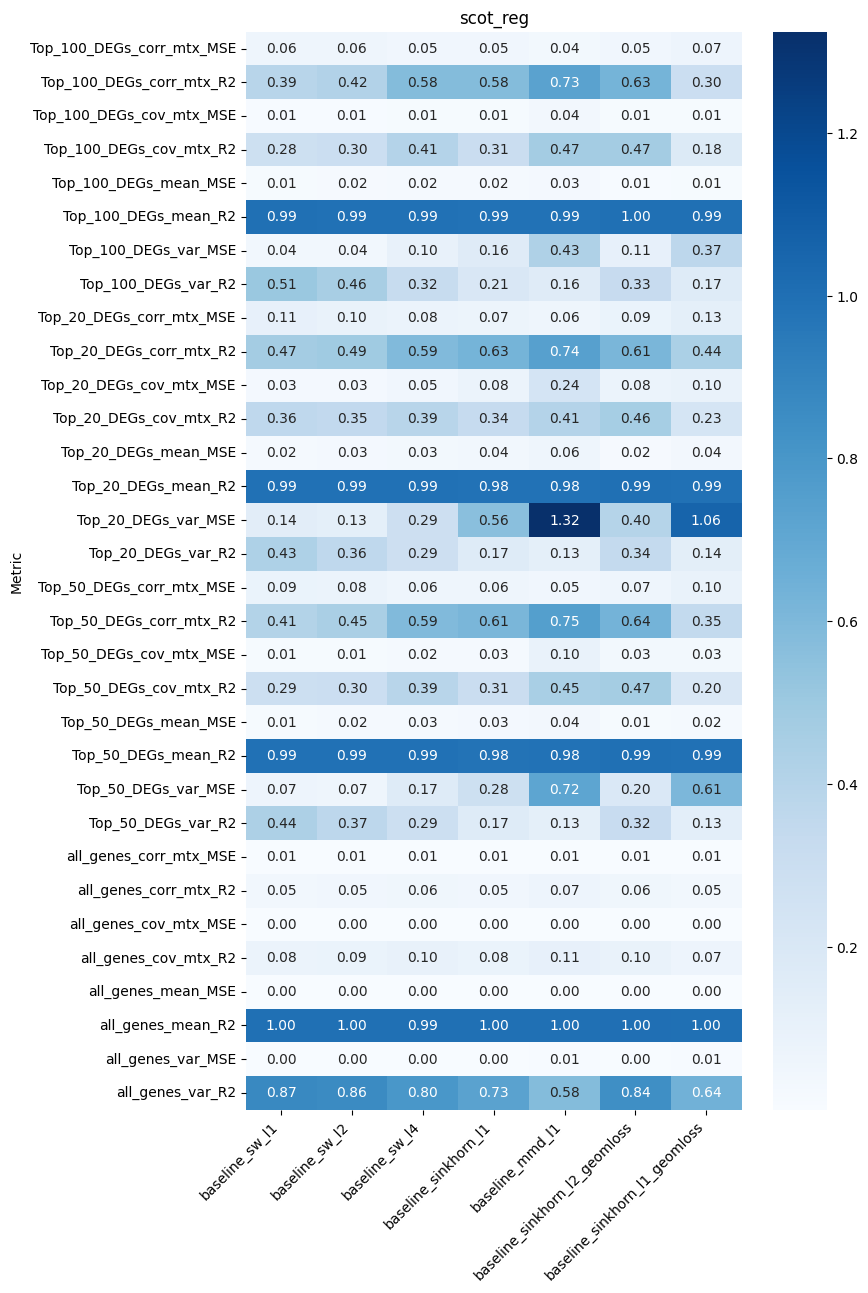

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle

# Sample Data (Replace with your actual data)
data = {
    "Metric": [
        "Top_100_DEGs_corr_mtx_MSE", "Top_100_DEGs_corr_mtx_R2", "Top_100_DEGs_cov_mtx_MSE", "Top_100_DEGs_cov_mtx_R2",
        "Top_100_DEGs_mean_MSE", "Top_100_DEGs_mean_R2", "Top_100_DEGs_var_MSE", "Top_100_DEGs_var_R2",
        "Top_20_DEGs_corr_mtx_MSE", "Top_20_DEGs_corr_mtx_R2", "Top_20_DEGs_cov_mtx_MSE", "Top_20_DEGs_cov_mtx_R2",
        "Top_20_DEGs_mean_MSE", "Top_20_DEGs_mean_R2", "Top_20_DEGs_var_MSE", "Top_20_DEGs_var_R2",
        "Top_50_DEGs_corr_mtx_MSE", "Top_50_DEGs_corr_mtx_R2", "Top_50_DEGs_cov_mtx_MSE", "Top_50_DEGs_cov_mtx_R2",
        "Top_50_DEGs_mean_MSE", "Top_50_DEGs_mean_R2", "Top_50_DEGs_var_MSE", "Top_50_DEGs_var_R2",
        "all_genes_corr_mtx_MSE", "all_genes_corr_mtx_R2", "all_genes_cov_mtx_MSE", "all_genes_cov_mtx_R2",
        "all_genes_mean_MSE", "all_genes_mean_R2", "all_genes_var_MSE", "all_genes_var_R2"
    ]
}

# Create DataFrame
df = pd.DataFrame(data)
df.set_index("Metric", inplace=True)

files = ['baseline_sw_l1_r2.pkl','baseline_sw_l2_r2.pkl','baseline_sw_l4_r2.pkl','baseline_sinkhorn_l1_r2.pkl',
         'baseline_mmd_l1_r2.pkl','baseline_sinkhorn_l2_geomloss_r2.pkl','baseline_sinkhorn_l1_geomloss_r2.pkl']
for filename in files:
    with open("./loss_results/" + filename, 'rb') as f:
        result_dict = pickle.load(f)
    new_data = result_dict
    new_df = pd.DataFrame.from_dict(new_data, orient='index', columns=[filename[:-7]])
    df = df.merge(new_df, left_index=True, right_index=True, how="left")

# Create heatmap
plt.figure(figsize=(8, 14))
ax = sns.heatmap(df, annot=True, cmap="Blues", fmt=".2f")

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')
plt.title("scot_reg")

# Show plot
plt.show()


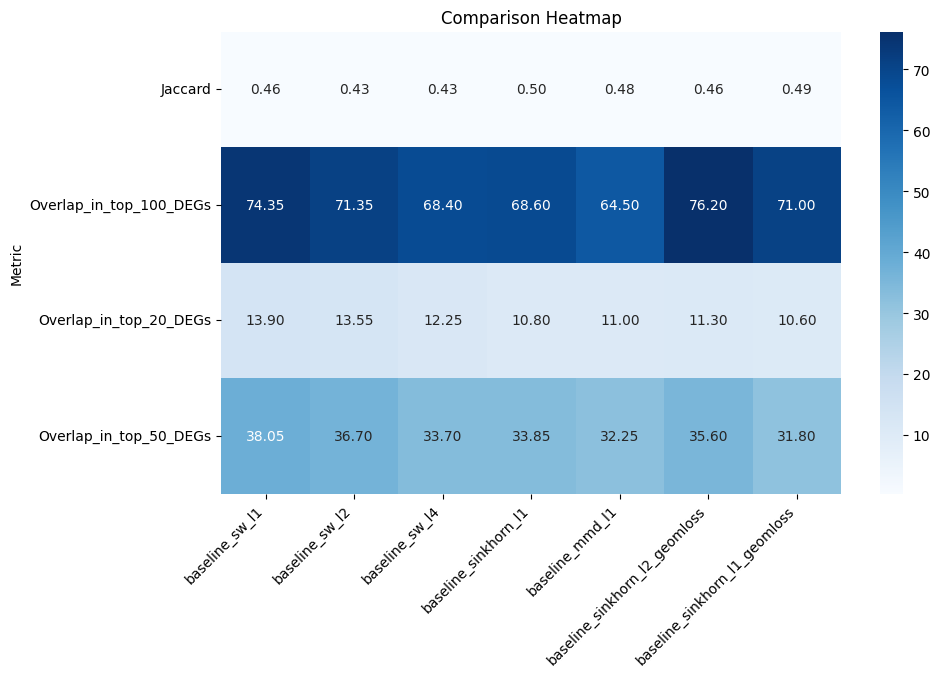

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Sample Data (Replace with actual values)
data = {
    "Metric": [
        "Jaccard", 
        "Overlap_in_top_100_DEGs", 
        "Overlap_in_top_20_DEGs", 
        "Overlap_in_top_50_DEGs"
    ]
}

# Create DataFrame
df = pd.DataFrame(data)
df.set_index("Metric", inplace=True)
files = ['baseline_sw_l1_deg.pkl','baseline_sw_l2_deg.pkl','baseline_sw_l4_deg.pkl','baseline_sinkhorn_l1_deg.pkl',
         'baseline_mmd_l1_deg.pkl','baseline_sinkhorn_l2_geomloss_deg.pkl','baseline_sinkhorn_l1_geomloss_deg.pkl']

#files = ['0_proportional_scot_deg.pkl','1_baseline_scot_20_epochs_deg.pkl','1_pert_embed_gnn_15_epochs_deg.pkl','2_pert_embed_gnn_20_epochs_deg.pkl','2_pert_embed_gnn_30_epochs_deg.pkl','2_pert_embed_gnn_100_epochs_deg.pkl',
 #        '3_pert_embed_gnn_cell_gnn_20_epochs_deg.pkl','4_pert_embed_cell_gnn_20_epochs_deg.pkl','4_pert_embed_cell_gnn_40_epochs_deg.pkl','5_sinkhorn_pert_embed_cell_gnn_20_epochs_deg.pkl',
 #        '6_mmd_pert_embed_cell_gnn_20_epochs_deg.pkl','7_flexible_shift_pert_embed_cell_gnn_20_epochs_deg.pkl']

for filename in files:
    with open("./loss_results/" +filename, 'rb') as f:
        result_dict = pickle.load(f)
    new_data = result_dict
    new_df = pd.DataFrame.from_dict(new_data, orient='index', columns=[filename[:-8]])
    df = df.merge(new_df, left_index=True, right_index=True, how="left")
# Create heatmap
#df.rename(columns = {'0_proportional_scot':'0_Proportional', '1_Baseline Scot 20 epochs':'1_Baseline_20_epochs','1_pert_embed_gnn_15_epochs':'2_Pert_embedding_20_epochs',
#                    '4_pert_embed_cell_gnn_20_epochs':'3_Pert embed + cell GNN 20 epochs','2_pert_embed_gnn_20_epochs':'4_Pert embed GNN 20 epochs',
#                    '3_pert_embed_gnn_cell_gnn_20_epochs':'5_Pert embed GNN + cell GNN 20 epochs'
 #                   }, inplace  = True)
#df = df.sort_index(axis=1)
plt.figure(figsize=(10, 6))
ax = sns.heatmap(df, annot=True, cmap="Blues", fmt=".2f")

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')
plt.title("Comparison Heatmap")

# Show plot
plt.show()
